## Initialization library, data, & function

In [1]:
#load all the necessary python libraries to preprocess the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scipy.stats import norm, skew

pd.options.display.float_format = "{:.2f}".format # float format 2 number in decimal, by kobud


In [2]:
import shap
shap.initjs()

In [3]:
# load data
df_ojol = pd.read_csv('dsa_ojol_dataset_clean1_v2.csv',delimiter="|")

In [4]:
# add by kobud
# referensi fungsi

# fungsi untuk menampilkan count of unique variabel
def showCountUniqueVariable(df):
    unique_counts = pd.DataFrame.from_records([(col, df[col].nunique(), df.dtypes[col]) 
                                           for col in df.columns],
                                          columns=['Column_Name', 'Num_Unique','Data_Type']).sort_values(by=['Num_Unique'])
    print(unique_counts)

# fungsi untuk memindah target variable ke last
def dependentToEndCol(df, colName):
    cols = list(df.columns.values)
    cols.pop(cols.index(colName))
    df = df[cols+[colName]]
    
    return df

# fungsi untuk cek missing value pada DF
def checkMissingValues(df):
    missing_data_clean = pd.DataFrame({'total_missing':df.isnull().sum(), 
                                     '%missing':(df.isnull().sum())/(df.isnull().count())*100})
    missing_data_clean = missing_data_clean[missing_data_clean['total_missing']>0]
    
    return missing_data_clean

# fungsi untuk variable baru numerical dan categorical
def defineNumCatCol(df):
    col_num = df.loc[:,df.dtypes != 'category'].columns
    col_cat = df.loc[:,df.dtypes == 'category'].columns
    col_type = {'col_num':col_num, 'col_cat':col_cat}
    
    return col_type

# fungsi konversi ke numerical & categorical variable by threshold jumlah unik values
def convertToCategoryType(df, tresh):
    treshold = tresh
    for col in df.columns:
        if df[col].nunique() < treshold:
            df[col] = df[col].astype('category')
    
    return df

# fungsi hitung banyak outliers
def numberOfOutliers(df, col_num):
    colname = [] 
    outlier = []
    percent = []
    for col_name in col_num:
        q1 = df[col_name].quantile(0.25)
        q3 = df[col_name].quantile(0.75)
        iqr = q3 - q1
        low = q1-(1.5*iqr)
        high = q1+(1.5*iqr)
        outliers1 = (len(df.loc[((df[col_name] < low) | (df[col_name] > high)), col_name]))
        outliers2 = ((len(df.loc[((df[col_name] < low) | (df[col_name] > high)), col_name]))/len(df_ojol))*100 
        colname.append(col_name)
        outlier.append(outliers1)
        percent.append("%.2f"%outliers2)
        
    df_outliers = pd.DataFrame({'col_name':colname, 'outlier':outlier, 'percent':percent})
    return df_outliers

# DATA UNDERSTANDING

## Data Description

In [5]:
print("{} rows x {} columns".format(df_ojol.shape[0], df_ojol.shape[1])) 

695597 rows x 31 columns


In [6]:
df_ojol.head()

msisdn  mytsel_app_user  total_revenue  rev_voice  rev_sms  \
0  628111563256                1          10092       8132      800   
1  628112589620                0         133657     131622     1410   
2  628112821723                0          30006      28556     1450   
3  628113288867                1          44503       7133      200   
4  628113917571                1           5073       4473      600   

   rev_broadband  rev_voice_pack  rev_sms_pack  rev_data_pack  \
0              0               0             0              0   
1              0               0             0              0   
2              0               0             0              0   
3              0               0             0              0   
4              0               0             0              0   

   rev_pack_mytsel  ...  trx_sms_offnet   payload  total_recharge_mytsel  \
0                0  ...               0   9229653                      0   
1                0  ...               1   3668863                      0   
2                0  ...               5   2097283                      0   
3                0  ...               0   1974025                      0   
4                0  ...               0  10023262                      0   

   total_recharge_urp                region  flag_taker   los  \
0                   0  06.Eastern Jabotabek           0  1506   
1                   0             08.Jateng           0  1349   
2                   0             08.Jateng           0   775   
3                   0              09.Jatim           0  1485   
4                   0          10.Balinusra           0  1130   

   first_rank_category  ojol  total_recharge  
0       Transportation     Y           10000  
1       Transportation   NaN          135000  
2       Transportation   NaN           30000  
3                Games     Y           15000  
4       Transportation     Y           15000  

[5 rows x 31 columns]

In [7]:
df_ojol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 695597 entries, 0 to 695596
Data columns (total 31 columns):
msisdn                   695597 non-null int64
mytsel_app_user          695597 non-null int64
total_revenue            695597 non-null int64
rev_voice                695597 non-null int64
rev_sms                  695597 non-null int64
rev_broadband            695597 non-null int64
rev_voice_pack           695597 non-null int64
rev_sms_pack             695597 non-null int64
rev_data_pack            695597 non-null int64
rev_pack_mytsel          695597 non-null int64
rev_voice_pack_mytsel    695597 non-null int64
rev_sms_pack_mytsel      695597 non-null int64
rev_data_pack_mytsel     695597 non-null int64
trx_voice                695597 non-null int64
trx_voice_onnet          695597 non-null int64
trx_voice_offnet         695597 non-null int64
mou_voice                695597 non-null int64
mou_voice_onnet          695597 non-null int64
mou_voice_offnet         695597 non-null in

int64     28
object     3
dtype: int64


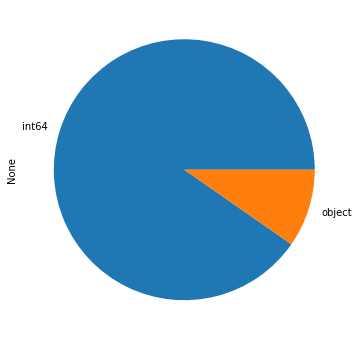

In [8]:
dcounts = df_ojol.get_dtype_counts()
print(dcounts)
labels = dcounts
plot = dcounts.plot.pie(figsize=(9, 6))

In [9]:
df_ojol.describe().T

count             mean             std  \
msisdn                695597.00 6213143252677.72 620748564892.81   
mytsel_app_user       695597.00             0.51            0.50   
total_revenue         695597.00        128579.33       102929.63   
rev_voice             695597.00          9242.30        24154.94   
rev_sms               695597.00          1050.81         3917.84   
rev_broadband         695597.00        108742.35        79503.47   
rev_voice_pack        695597.00          3547.87        15946.35   
rev_sms_pack          695597.00            28.40         1274.28   
rev_data_pack         695597.00        104254.60        77403.42   
rev_pack_mytsel       695597.00         12642.86        58688.35   
rev_voice_pack_mytsel 695597.00             0.00            0.00   
rev_sms_pack_mytsel   695597.00             0.00            0.00   
rev_data_pack_mytsel  695597.00             0.00            0.00   
trx_voice             695597.00           106.68          143.39   
trx_voice_onnet       695597.00            81.43          122.59   
trx_voice_offnet      695597.00            22.41           35.30   
mou_voice             695597.00           176.65          388.53   
mou_voice_onnet       695597.00           151.30          380.80   
mou_voice_offnet      695597.00            19.88           38.70   
trx_sms               695597.00            16.19           94.42   
trx_sms_onnet         695597.00            13.20           78.48   
trx_sms_offnet        695597.00             2.66           36.88   
payload               695597.00      18562070.84     14422572.88   
total_recharge_mytsel 695597.00           710.40        27239.89   
total_recharge_urp    695597.00             0.00            0.00   
flag_taker            695597.00             0.57            0.50   
los                   695597.00          1630.23         1787.72   
total_recharge        695597.00        129171.29       125605.14   

                                  min              25%              50%  \
msisdn                628111563256.00 6281289284999.00 6281381932980.00   
mytsel_app_user                  0.00             0.00             1.00   
total_revenue                    3.00         75460.00         99196.00   
rev_voice                        0.00             0.00             0.00   
rev_sms                          0.00             0.00           165.00   
rev_broadband                    0.00         75000.00         78801.00   
rev_voice_pack                   0.00             0.00             0.00   
rev_sms_pack                     0.00             0.00             0.00   
rev_data_pack                    0.00         75000.00         75000.00   
rev_pack_mytsel                  0.00             0.00             0.00   
rev_voice_pack_mytsel            0.00             0.00             0.00   
rev_sms_pack_mytsel              0.00             0.00             0.00   
rev_data_pack_mytsel             0.00             0.00             0.00   
trx_voice                        1.00            19.00            55.00   
trx_voice_onnet                  0.00            11.00            36.00   
trx_voice_offnet                 0.00             2.00             9.00   
mou_voice                        0.00            19.00            69.00   
mou_voice_onnet                  0.00             9.00            43.00   
mou_voice_offnet                 0.00             1.00             6.00   
trx_sms                          1.00             2.00             5.00   
trx_sms_onnet                    0.00             1.00             3.00   
trx_sms_offnet                   0.00             0.00             0.00   
payload                          1.00       8643818.00      16331959.00   
total_recharge_mytsel            0.00             0.00             0.00   
total_recharge_urp               0.00             0.00             0.00   
flag_taker                       0.00             0.00             1.00   
los                         

## Explore Data

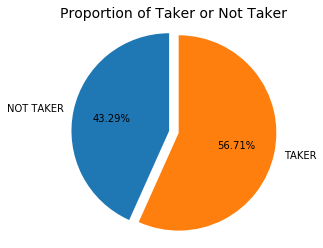

In [10]:
labels = 'NOT TAKER', 'TAKER'
sizes = [df_ojol.flag_taker[df_ojol['flag_taker']==0].count(), df_ojol.flag_taker[df_ojol['flag_taker']==1].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(4, 4))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%',
        startangle=90)
ax1.axis('equal')
plt.title("Proportion of Taker or Not Taker", size=14)
plt.show()

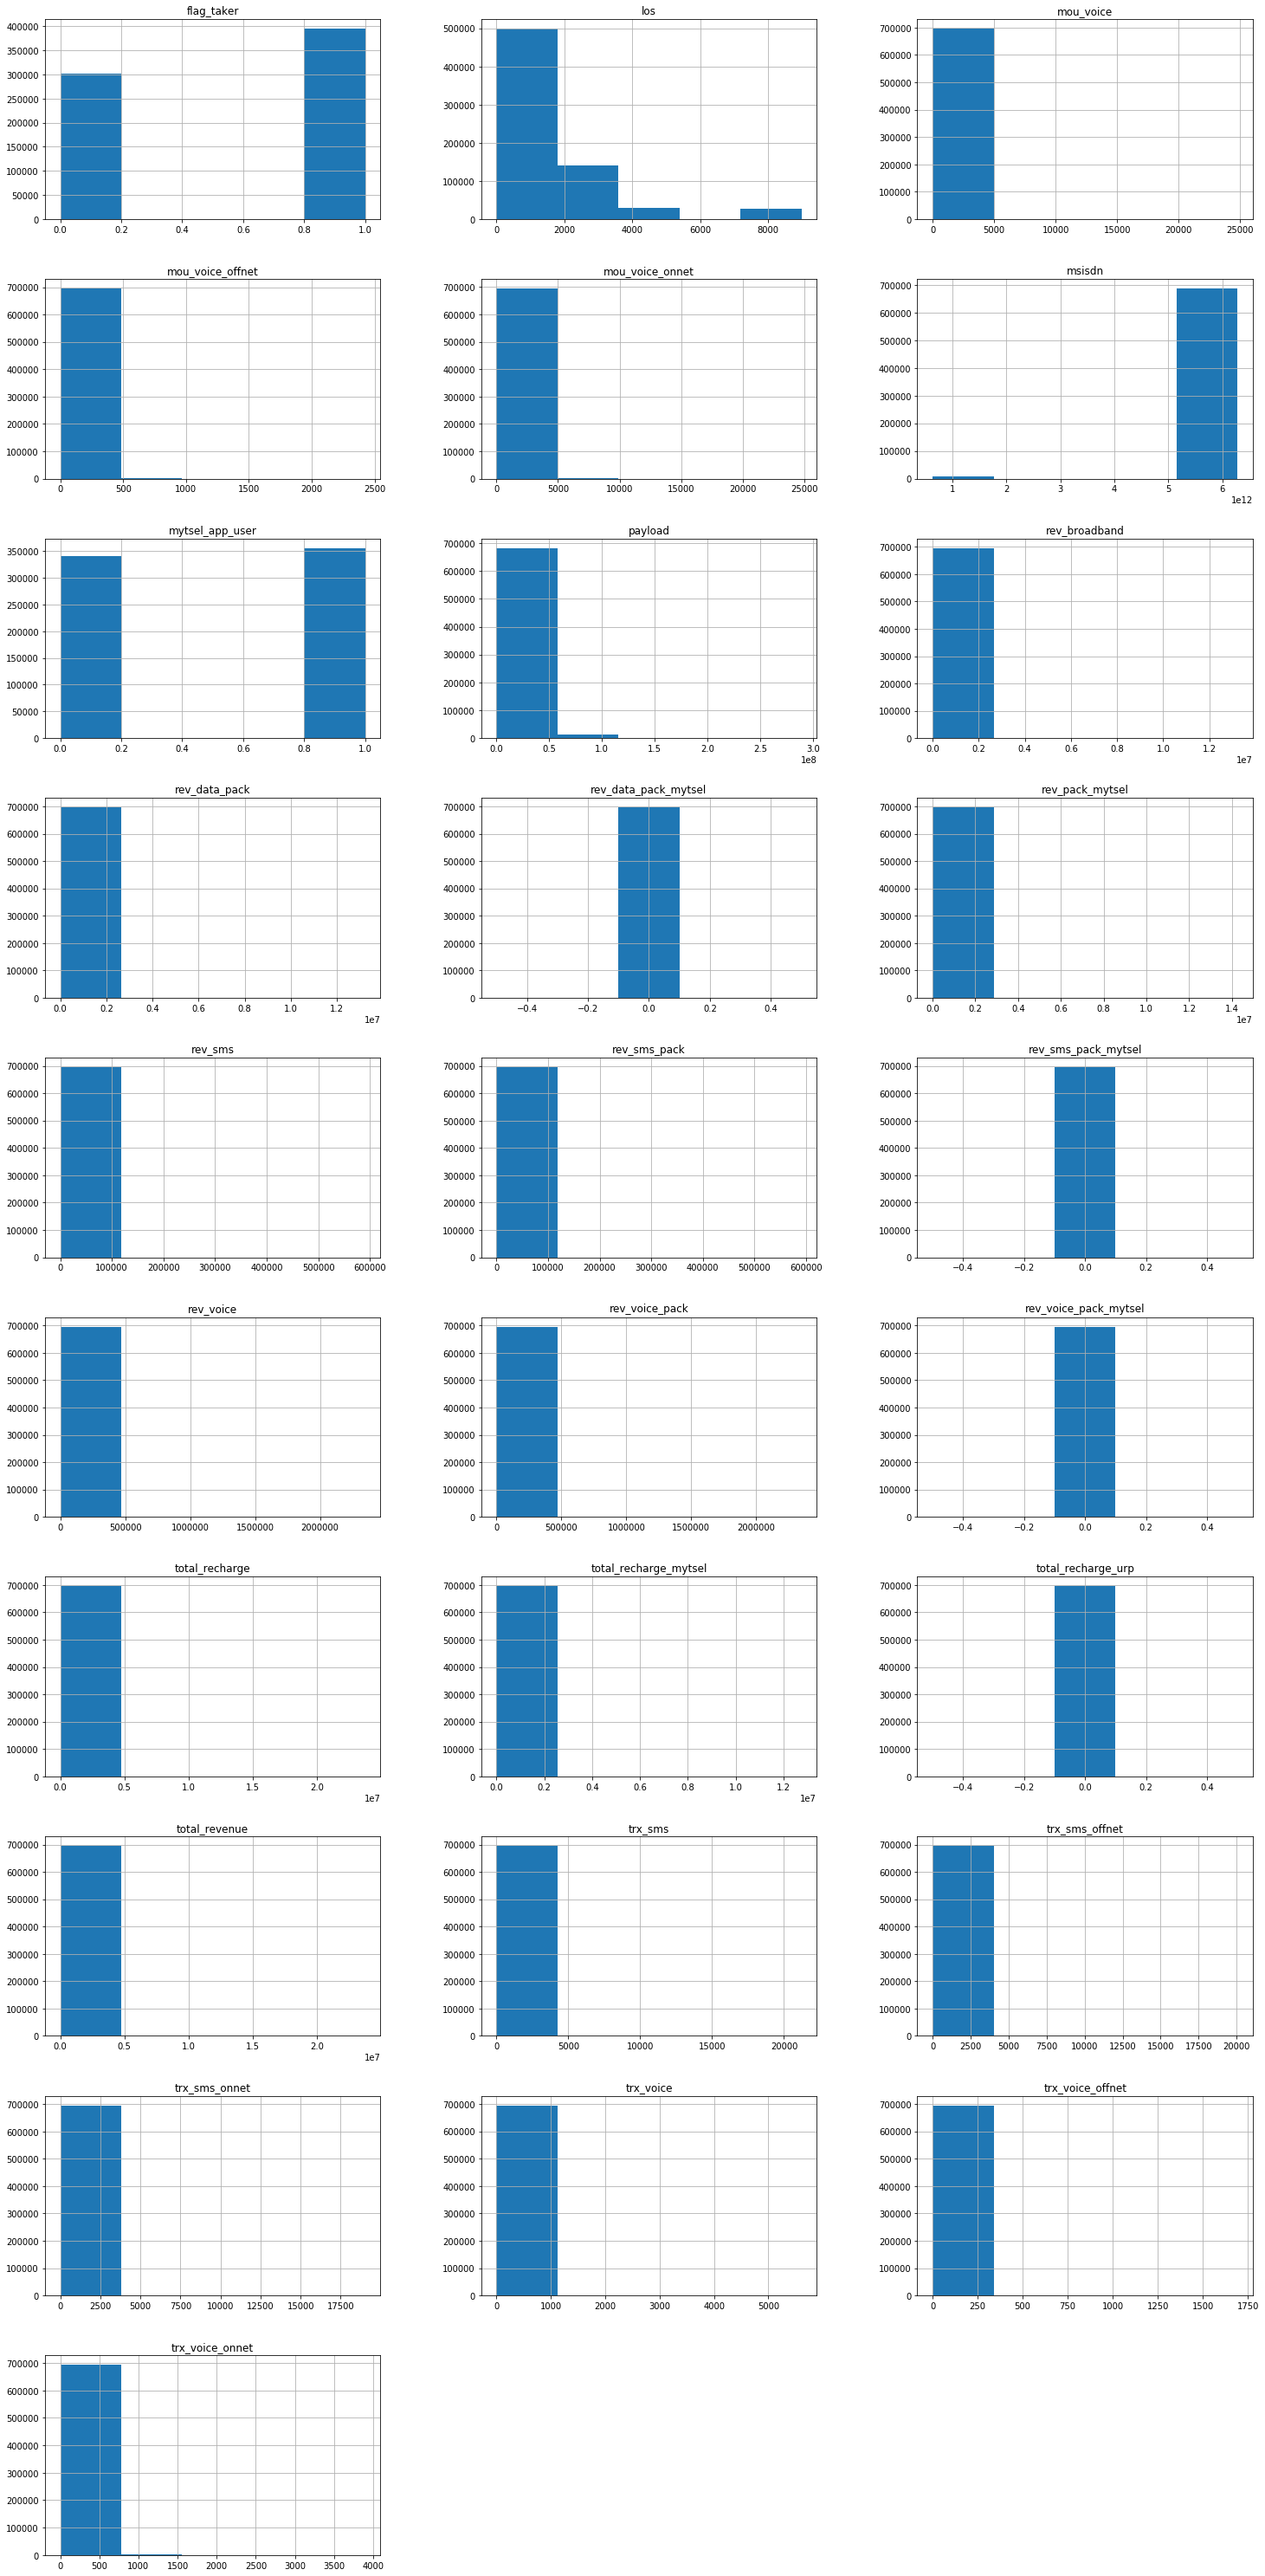

In [11]:
#Checking data distribution
df_ojol.hist(bins=5, figsize=(25, 120), layout=(22, 3));

[]

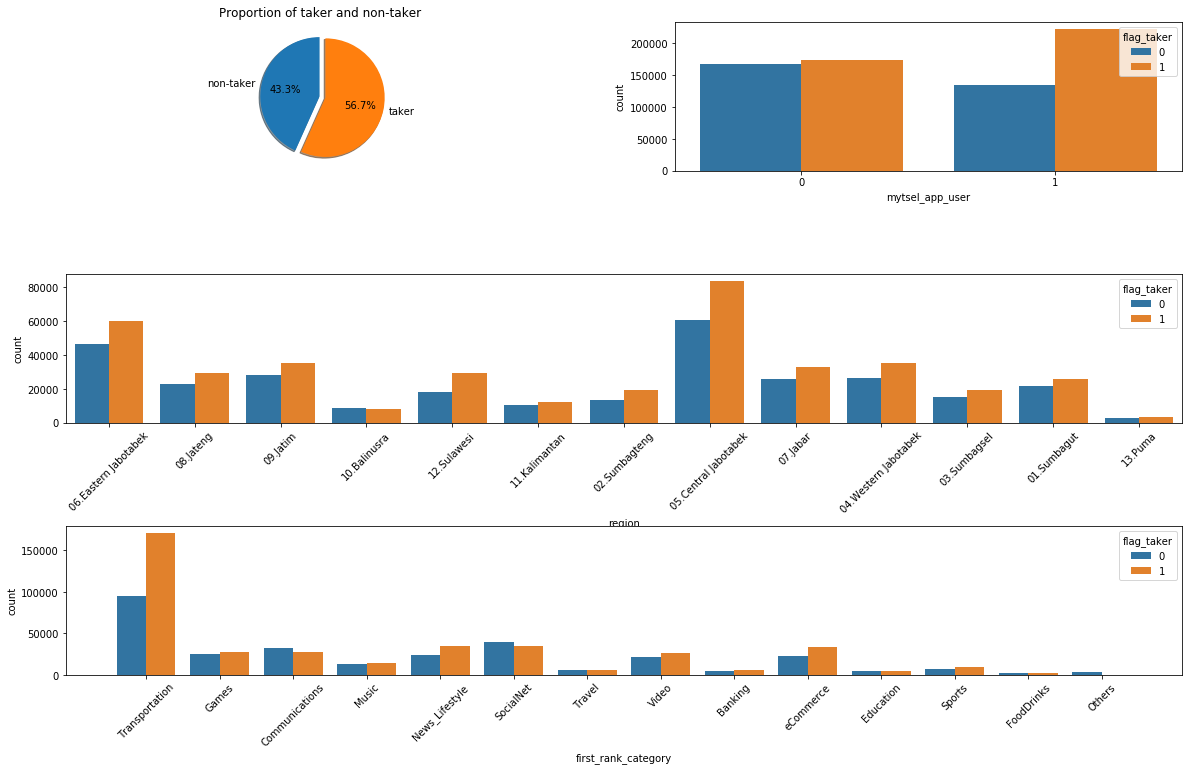

In [12]:
# add by kobud

plt.figure(figsize=(20,12))
ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=1)
ax2 = plt.subplot2grid((3, 2), (0, 1), colspan=1)
ax3 = plt.subplot2grid((3, 2), (1, 0), colspan=2)
ax3.tick_params('x', labelrotation=45)
ax4 = plt.subplot2grid((3, 2), (2, 0), colspan=2)
ax4.tick_params('x', labelrotation=45)

ax1.set_title('Proportion of taker and non-taker')

labels = 'non-taker', 'taker'
sizes = [df_ojol.flag_taker[df_ojol['flag_taker']==0].count(), df_ojol.flag_taker[df_ojol['flag_taker']==1].count()]
explode = (0, 0.1)
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

sns.countplot(x='mytsel_app_user', hue = 'flag_taker',data = df_ojol, ax=ax2)
sns.countplot(x='region', hue = 'flag_taker',data = df_ojol, ax=ax3)
sns.countplot(x='first_rank_category', hue = 'flag_taker',data = df_ojol, ax=ax4)

# plt.margins(0.9)
plt.subplots_adjust(hspace=.7)
plt.plot()


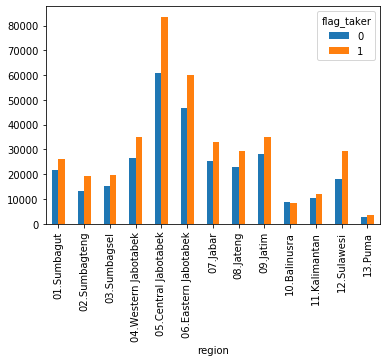

In [13]:
df_ojol.groupby('flag_taker').region.value_counts().unstack(0).plot.bar()

## Duplicate Data

In [14]:
df_ojol.duplicated().sum()

0

## Missing Values

In [15]:
checkMissingValues(df_ojol)

total_missing  %missing
first_rank_category           5078      0.73
ojol                        340026     48.88

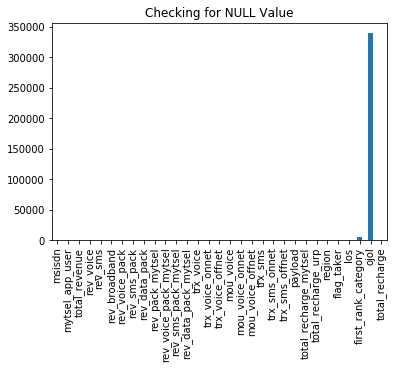

In [16]:
ojol_miss = df_ojol.isnull().sum().plot(kind='bar', title='Checking for NULL Value');

In [17]:
print("NULL: ", df_ojol['first_rank_category'].isnull().sum())
print("Not NULL: ", df_ojol['first_rank_category'].notnull().sum())

NULL:  5078
Not NULL:  690519


In [18]:
print("NULL: ", df_ojol['ojol'].isnull().sum())
print("Not NULL: ", df_ojol['ojol'].notnull().sum())

NULL:  340026
Not NULL:  355571


## Numerical & Categorical

In [19]:
showCountUniqueVariable(df_ojol)

              Column_Name  Num_Unique Data_Type
24     total_recharge_urp           1     int64
10  rev_voice_pack_mytsel           1     int64
11    rev_sms_pack_mytsel           1     int64
12   rev_data_pack_mytsel           1     int64
29                   ojol           1    object
1         mytsel_app_user           2     int64
26             flag_taker           2     int64
25                 region          13    object
28    first_rank_category          14    object
23  total_recharge_mytsel         111     int64
7            rev_sms_pack         209     int64
21         trx_sms_offnet         442     int64
15       trx_voice_offnet         469     int64
18       mou_voice_offnet         671     int64
30         total_recharge        1114     int64
20          trx_sms_onnet        1258     int64
19                trx_sms        1291     int64
14        trx_voice_onnet        1309     int64
13              trx_voice        1423     int64
9         rev_pack_mytsel        3674   

In [20]:
# add by Kobud
df_ojol = convertToCategoryType(df_ojol, 111)

In [21]:
showCountUniqueVariable(df_ojol)

              Column_Name  Num_Unique Data_Type
24     total_recharge_urp           1  category
10  rev_voice_pack_mytsel           1  category
11    rev_sms_pack_mytsel           1  category
12   rev_data_pack_mytsel           1  category
29                   ojol           1  category
1         mytsel_app_user           2  category
26             flag_taker           2  category
25                 region          13  category
28    first_rank_category          14  category
23  total_recharge_mytsel         111     int64
7            rev_sms_pack         209     int64
21         trx_sms_offnet         442     int64
15       trx_voice_offnet         469     int64
18       mou_voice_offnet         671     int64
30         total_recharge        1114     int64
20          trx_sms_onnet        1258     int64
19                trx_sms        1291     int64
14        trx_voice_onnet        1309     int64
13              trx_voice        1423     int64
9         rev_pack_mytsel        3674   

In [22]:
# add by kobud
col_type = defineNumCatCol(df_ojol)

display(df_ojol[col_type['col_num']].head())
display(df_ojol[col_type['col_cat']].head())

msisdn  total_revenue  rev_voice  rev_sms  rev_broadband  \
0  628111563256          10092       8132      800              0   
1  628112589620         133657     131622     1410              0   
2  628112821723          30006      28556     1450              0   
3  628113288867          44503       7133      200              0   
4  628113917571           5073       4473      600              0   

   rev_voice_pack  rev_sms_pack  rev_data_pack  rev_pack_mytsel  trx_voice  \
0               0             0              0                0         25   
1               0             0              0                0        186   
2               0             0              0                0         36   
3               0             0              0                0         22   
4               0             0              0                0        116   

   ...  mou_voice  mou_voice_onnet  mou_voice_offnet  trx_sms  trx_sms_onnet  \
0  ...          6                2                 3        4              4   
1  ...        102               63                38        7              6   
2  ...         21                4                16        7              2   
3  ...         21               17                 3        1              1   
4  ...        147              147                 0        6              6   

   trx_sms_offnet   payload  total_recharge_mytsel   los  total_recharge  
0               0   9229653                      0  1506           10000  
1               1   3668863                      0  1349          135000  
2               5   2097283                      0   775           30000  
3               0   1974025                      0  1485           15000  
4               0  10023262                      0  1130           15000  

[5 rows x 22 columns]

mytsel_app_user rev_voice_pack_mytsel rev_sms_pack_mytsel  \
0               1                     0                   0   
1               0                     0                   0   
2               0                     0                   0   
3               1                     0                   0   
4               1                     0                   0   

  rev_data_pack_mytsel total_recharge_urp                region flag_taker  \
0                    0                  0  06.Eastern Jabotabek          0   
1                    0                  0             08.Jateng          0   
2                    0                  0             08.Jateng          0   
3                    0                  0              09.Jatim          0   
4                    0                  0          10.Balinusra          0   

  first_rank_category ojol  
0      Transportation    Y  
1      Transportation  NaN  
2      Transportation  NaN  
3               Games    Y  
4      Transportation    Y

## Outliers

### Using the Interquartile Range (IQR)

In [23]:
# edited by kobud

Q1 = df_ojol.loc[:,col_type['col_num']].quantile(0.25)
Q3 = df_ojol.loc[:,col_type['col_num']].quantile(0.75)
IQR = Q3-Q1
Lower_Bound = Q1-(1.5*IQR)
Upper_Bound = Q3+(1.5*IQR)

outlier = pd.DataFrame({'Q1':Q1,'Q3':Q3,'IQR':IQR,'Lower_Bound':Lower_Bound,'Upper_Bound':Upper_Bound})
pd.options.display.float_format = '{:.0f}'.format
outlier

# Anything outside of lower_bound and upper_bound is an outlier.

Q1            Q3       IQR   Lower_Bound  \
msisdn                6281289284999 6282245001600 955716601 6279855710098   
total_revenue                 75460        160001     84541        -51352   
rev_voice                         0          7467      7467        -11200   
rev_sms                           0           825       825         -1238   
rev_broadband                 75000        150000     75000        -37500   
rev_voice_pack                    0             0         0             0   
rev_sms_pack                      0             0         0             0   
rev_data_pack                 75000        150000     75000        -37500   
rev_pack_mytsel                   0             0         0             0   
trx_voice                        19           135       116          -155   
trx_voice_onnet                  11            99        88          -121   
trx_voice_offnet                  2            28        26           -37   
mou_voice                        19           191       172          -239   
mou_voice_onnet                   9           151       142          -204   
mou_voice_offnet                  1            23        22           -32   
trx_sms                           2            12        10           -13   
trx_sms_onnet                     1             8         7           -10   
trx_sms_offnet                    0             2         2            -3   
payload                     8643818      24959036  16315218     -15829009   
total_recharge_mytsel             0             0         0             0   
los                             567          1977      1410         -1548   
total_recharge                75000        160000     85000        -52500   

                        Upper_Bound  
msisdn                6283678576502  
total_revenue                286812  
rev_voice                     18668  
rev_sms                        2062  
rev_broadband                262500  
rev_voice_pack                    0  
rev_sms_pack                      0  
rev_data_pack                262500  
rev_pack_mytsel                   0  
trx_voice                       309  
trx_voice_onnet                 231  
trx_voice_offnet                 67  
mou_voice                       449  
mou_voice_onnet                 364  
mou_voice_offnet                 56  
trx_sms                          27  
trx_sms_onnet                    18  
trx_sms_offnet                    5  
payload                    49431863  
total_recharge_mytsel             0  
los                            4092  
total_recharge               287500

### Number of Outliers

In [24]:
# edited by Kobud
display(numberOfOutliers(df_ojol, col_type['col_num']))

col_name  outlier percent
0                  msisdn   105523   15.17
1           total_revenue   101402   14.58
2               rev_voice   139850   20.11
3                 rev_sms   128426   18.46
4           rev_broadband    83030   11.94
5          rev_voice_pack   106021   15.24
6            rev_sms_pack     2240    0.32
7           rev_data_pack    76243   10.96
8         rev_pack_mytsel    75485   10.85
9               trx_voice   114058   16.40
10        trx_voice_onnet   117866   16.94
11       trx_voice_offnet   115970   16.67
12              mou_voice   118329   17.01
13        mou_voice_onnet   124684   17.92
14       mou_voice_offnet   116365   16.73
15                trx_sms   119116   17.12
16          trx_sms_onnet   133550   19.20
17         trx_sms_offnet   109752   15.78
18                payload    91819   13.20
19  total_recharge_mytsel     3484    0.50
20                    los   109963   15.81
21         total_recharge   100026   14.38

(0.0, 1.0, 0.0, 1.0)

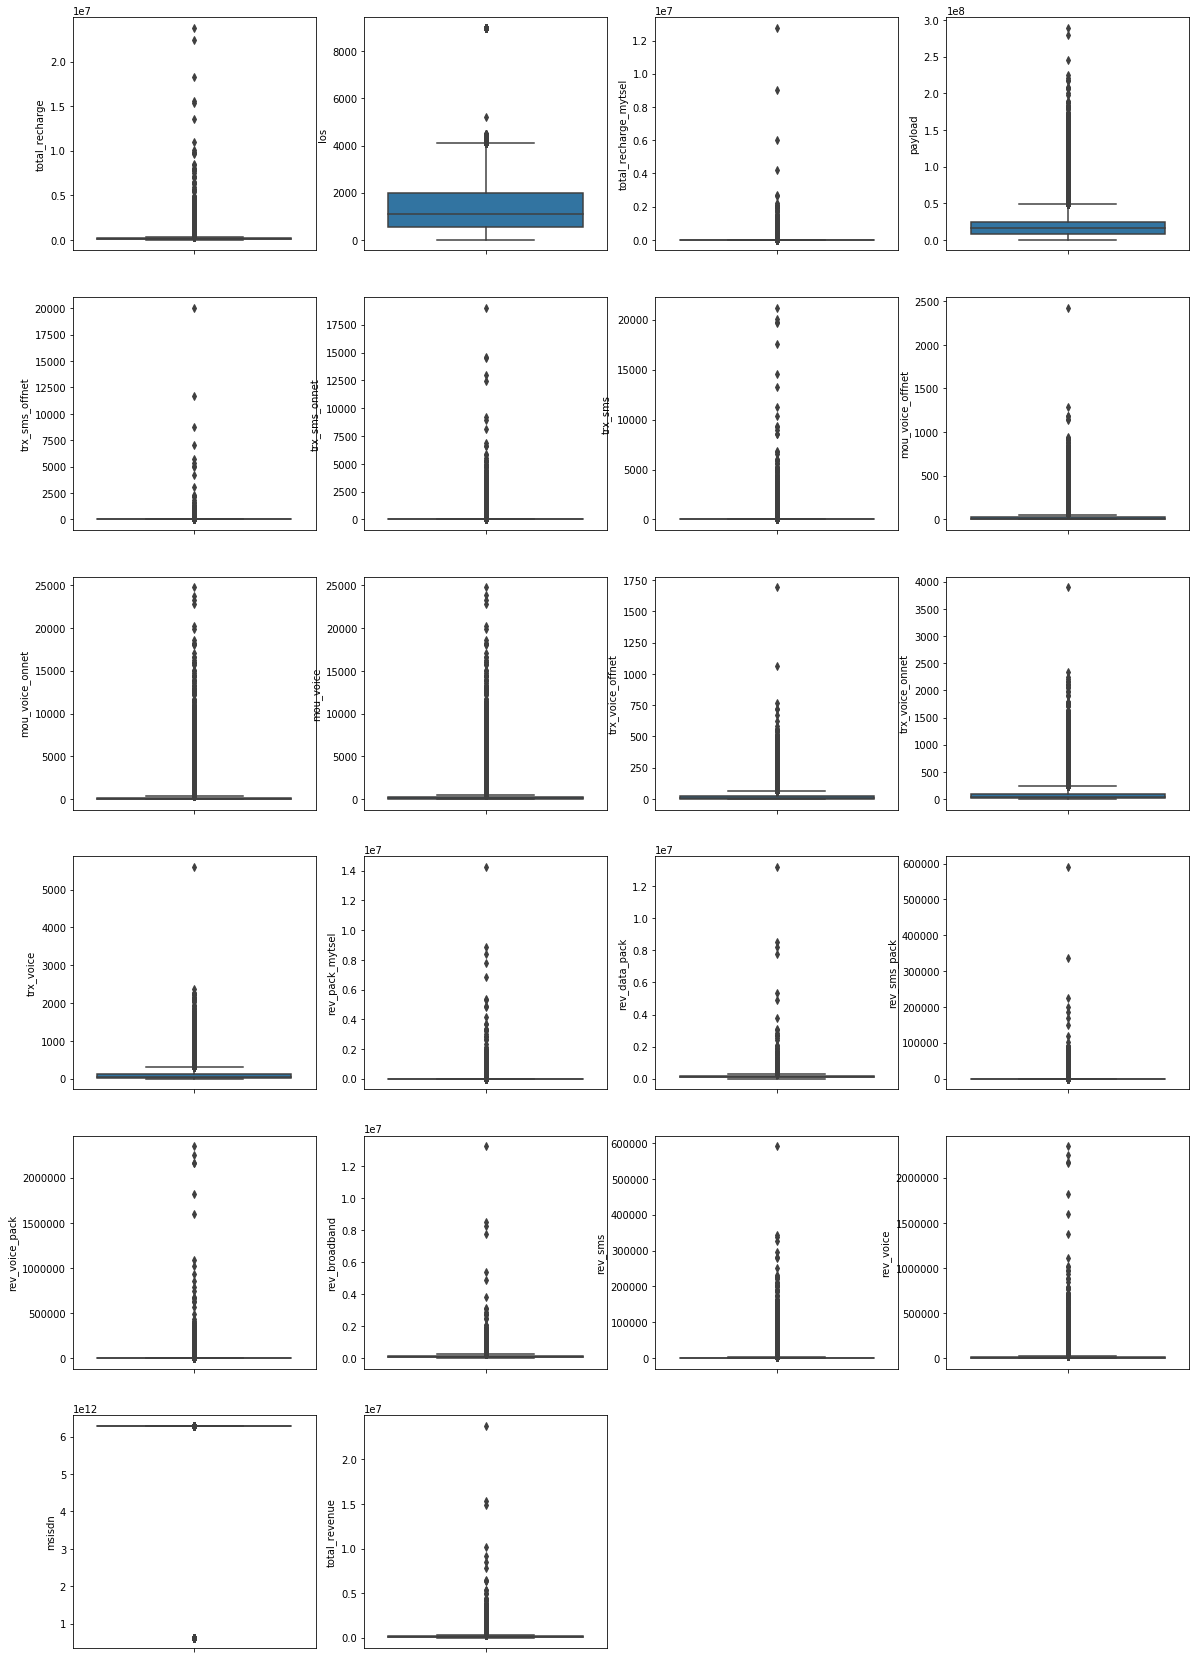

In [25]:
#edited by kobud
# Edited by Amal: col_num -> col_type['col_num']

def convertColList(list, jml_col):
    b = []
    for i in a:
        c = []
        for j in range(jml_col):
            c.append(a.pop())
        b.append(c)
    b.append(a)
    return b

a = list(col_type['col_num'].copy())
b = convertColList(a,4)
# print(b)

n = 0
fig, axarr = plt.subplots(6, 4, figsize=(20, 30))
for i in b:
    m = 0
    for j in i:
        if j in col_type['col_num']:
            sns.boxplot(y=j, data = df_ojol , ax=axarr[n][m])

        m = m + 1
    n = n + 1

axarr[5, 2].axis('off')
axarr[5, 3].axis('off')



# DATA PREPARATION

## Data Preprocessing & Cleaning

In [26]:
df_ojol_prep = df_ojol.copy()

### Handling Missing Values

In [27]:
df_ojol_prep['ojol'].value_counts()

Y    355571
Name: ojol, dtype: int64

In [28]:
df_ojol_prep['ojol'] = df_ojol_prep['ojol'].replace(np.NaN,0).replace('Y',1)
df_ojol_prep.head(5)

msisdn mytsel_app_user  total_revenue  rev_voice  rev_sms  \
0  628111563256               1          10092       8132      800   
1  628112589620               0         133657     131622     1410   
2  628112821723               0          30006      28556     1450   
3  628113288867               1          44503       7133      200   
4  628113917571               1           5073       4473      600   

   rev_broadband  rev_voice_pack  rev_sms_pack  rev_data_pack  \
0              0               0             0              0   
1              0               0             0              0   
2              0               0             0              0   
3              0               0             0              0   
4              0               0             0              0   

   rev_pack_mytsel  ... trx_sms_offnet   payload total_recharge_mytsel  \
0                0  ...              0   9229653                     0   
1                0  ...              1   3668863                     0   
2                0  ...              5   2097283                     0   
3                0  ...              0   1974025                     0   
4                0  ...              0  10023262                     0   

   total_recharge_urp                region  flag_taker   los  \
0                   0  06.Eastern Jabotabek           0  1506   
1                   0             08.Jateng           0  1349   
2                   0             08.Jateng           0   775   
3                   0              09.Jatim           0  1485   
4                   0          10.Balinusra           0  1130   

   first_rank_category  ojol  total_recharge  
0       Transportation     1           10000  
1       Transportation     0          135000  
2       Transportation     0           30000  
3                Games     1           15000  
4       Transportation     1           15000  

[5 rows x 31 columns]

In [29]:
df_ojol_prep['ojol'].value_counts()

1    355571
0    340026
Name: ojol, dtype: int64

In [30]:
checkMissingValues(df_ojol_prep)

total_missing  %missing
first_rank_category           5078         1

In [31]:
df_ojol_prep['first_rank_category'] = df_ojol_prep['first_rank_category'].replace(np.NaN,'undefined')
df_ojol_prep['first_rank_category'].isnull().sum()

0

In [32]:
df_ojol_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 695597 entries, 0 to 695596
Data columns (total 31 columns):
msisdn                   695597 non-null int64
mytsel_app_user          695597 non-null category
total_revenue            695597 non-null int64
rev_voice                695597 non-null int64
rev_sms                  695597 non-null int64
rev_broadband            695597 non-null int64
rev_voice_pack           695597 non-null int64
rev_sms_pack             695597 non-null int64
rev_data_pack            695597 non-null int64
rev_pack_mytsel          695597 non-null int64
rev_voice_pack_mytsel    695597 non-null category
rev_sms_pack_mytsel      695597 non-null category
rev_data_pack_mytsel     695597 non-null category
trx_voice                695597 non-null int64
trx_voice_onnet          695597 non-null int64
trx_voice_offnet         695597 non-null int64
mou_voice                695597 non-null int64
mou_voice_onnet          695597 non-null int64
mou_voice_offnet         695597

In [33]:
showCountUniqueVariable(df_ojol_prep)

              Column_Name  Num_Unique Data_Type
24     total_recharge_urp           1  category
10  rev_voice_pack_mytsel           1  category
11    rev_sms_pack_mytsel           1  category
12   rev_data_pack_mytsel           1  category
1         mytsel_app_user           2  category
26             flag_taker           2  category
29                   ojol           2     int64
25                 region          13  category
28    first_rank_category          15    object
23  total_recharge_mytsel         111     int64
7            rev_sms_pack         209     int64
21         trx_sms_offnet         442     int64
15       trx_voice_offnet         469     int64
18       mou_voice_offnet         671     int64
30         total_recharge        1114     int64
20          trx_sms_onnet        1258     int64
19                trx_sms        1291     int64
14        trx_voice_onnet        1309     int64
13              trx_voice        1423     int64
9         rev_pack_mytsel        3674   

### Drop features that only have 1 unique value

In [34]:
#Added by Amal
print("{} rows x {} columns".format(df_ojol_prep.shape[0], df_ojol_prep.shape[1])) 

#Must be 31 columns

695597 rows x 31 columns


In [35]:
#Edited by Amal

#List all columns which contains only '0'
df_ojol_prep.loc[:, (df_ojol_prep != 0).any(axis=0)].columns

#This process removes total_recharge_urp, rev_voice_pack_mytsel, rev_sms_pack_mytsel, rev_data_pack_mytsel columns

Index(['msisdn', 'mytsel_app_user', 'total_revenue', 'rev_voice', 'rev_sms',
       'rev_broadband', 'rev_voice_pack', 'rev_sms_pack', 'rev_data_pack',
       'rev_pack_mytsel', 'trx_voice', 'trx_voice_onnet', 'trx_voice_offnet',
       'mou_voice', 'mou_voice_onnet', 'mou_voice_offnet', 'trx_sms',
       'trx_sms_onnet', 'trx_sms_offnet', 'payload', 'total_recharge_mytsel',
       'region', 'flag_taker', 'los', 'first_rank_category', 'ojol',
       'total_recharge'],
      dtype='object')

In [36]:
#Added by Amal
df_ojol_prep=df_ojol_prep.loc[:, (df_ojol_prep!=0).any(axis=0)]
print("{} rows x {} columns".format(df_ojol_prep.shape[0], df_ojol_prep.shape[1]))

#Must be 27 columns

695597 rows x 27 columns


In [37]:
showCountUniqueVariable(df_ojol_prep)

              Column_Name  Num_Unique Data_Type
1         mytsel_app_user           2  category
22             flag_taker           2  category
25                   ojol           2     int64
21                 region          13  category
24    first_rank_category          15    object
20  total_recharge_mytsel         111     int64
7            rev_sms_pack         209     int64
18         trx_sms_offnet         442     int64
12       trx_voice_offnet         469     int64
15       mou_voice_offnet         671     int64
26         total_recharge        1114     int64
17          trx_sms_onnet        1258     int64
16                trx_sms        1291     int64
11        trx_voice_onnet        1309     int64
10              trx_voice        1423     int64
9         rev_pack_mytsel        3674     int64
14        mou_voice_onnet        4294     int64
13              mou_voice        4339     int64
23                    los        4467     int64
4                 rev_sms        4545   

### Drop feature that have as many unique values as total data

In [38]:
# Only the msisdn column has the same unique value as the total data

df_ojol_prep = df_ojol_prep.drop(['msisdn'], axis = 1)

In [39]:
#Added by Amal
print("{} rows x {} columns".format(df_ojol_prep.shape[0], df_ojol_prep.shape[1])) 

#Must be 26 columns

695597 rows x 26 columns


In [40]:
showCountUniqueVariable(df_ojol_prep)

              Column_Name  Num_Unique Data_Type
0         mytsel_app_user           2  category
21             flag_taker           2  category
24                   ojol           2     int64
20                 region          13  category
23    first_rank_category          15    object
19  total_recharge_mytsel         111     int64
6            rev_sms_pack         209     int64
17         trx_sms_offnet         442     int64
11       trx_voice_offnet         469     int64
14       mou_voice_offnet         671     int64
25         total_recharge        1114     int64
16          trx_sms_onnet        1258     int64
15                trx_sms        1291     int64
10        trx_voice_onnet        1309     int64
9               trx_voice        1423     int64
8         rev_pack_mytsel        3674     int64
13        mou_voice_onnet        4294     int64
12              mou_voice        4339     int64
22                    los        4467     int64
3                 rev_sms        4545   

### Drop feature that have the same value as other features

In [41]:
# Added by Amal
# Features with the same number of unique values are mytsel_app_user, ojol and flag_taker. 
# But flag_taker is a dependent variable so it doesn't need to be checked.

df_ojol_prep.groupby(['ojol', 'mytsel_app_user']).size()

ojol  mytsel_app_user
0     0                  340026
1     1                  355571
dtype: int64

In [42]:
print("Ojol column has the same value as MyTsel column")
display(df_ojol_prep['ojol'].value_counts())
display(df_ojol_prep['mytsel_app_user'].value_counts())

Ojol column has the same value as MyTsel column


1    355571
0    340026
Name: ojol, dtype: int64

1    355571
0    340026
Name: mytsel_app_user, dtype: int64

In [43]:
df_ojol_prep = df_ojol_prep.drop(['ojol'], axis = 1)

In [44]:
#Added by Amal
print("{} rows x {} columns".format(df_ojol_prep.shape[0], df_ojol_prep.shape[1])) 

#Must be 25 columns

695597 rows x 25 columns


In [45]:
showCountUniqueVariable(df_ojol_prep)

              Column_Name  Num_Unique Data_Type
0         mytsel_app_user           2  category
21             flag_taker           2  category
20                 region          13  category
23    first_rank_category          15    object
19  total_recharge_mytsel         111     int64
6            rev_sms_pack         209     int64
17         trx_sms_offnet         442     int64
11       trx_voice_offnet         469     int64
14       mou_voice_offnet         671     int64
24         total_recharge        1114     int64
16          trx_sms_onnet        1258     int64
15                trx_sms        1291     int64
10        trx_voice_onnet        1309     int64
9               trx_voice        1423     int64
8         rev_pack_mytsel        3674     int64
13        mou_voice_onnet        4294     int64
12              mou_voice        4339     int64
22                    los        4467     int64
3                 rev_sms        4545     int64
5          rev_voice_pack        5235   

### Reshaping total_revenue to segment_arpu (grouping)

In [46]:
def segment_arpu(data):
    df_ojol_prep['segment_arpu'] = "NaN"
    df_ojol_prep.loc[(df_ojol_prep['total_revenue'] >= 0) & (df_ojol_prep['total_revenue'] <= 20000), 'segment_arpu'] = 'Very Low (<=20K)' 
    df_ojol_prep.loc[(df_ojol_prep['total_revenue'] > 20000) & (df_ojol_prep['total_revenue'] <= 50000), 'segment_arpu'] = 'Medium (20-50K)'
    df_ojol_prep.loc[(df_ojol_prep['total_revenue'] > 50000) & (df_ojol_prep['total_revenue'] <= 120000), 'segment_arpu'] = 'High (50-120K)'
    df_ojol_prep.loc[(df_ojol_prep['total_revenue'] > 120000) & (df_ojol_prep['total_revenue'] <= 250000), 'segment_arpu'] = 'Very High (120-250K)' 
    df_ojol_prep.loc[(df_ojol_prep['total_revenue'] > 250000), 'segment_arpu'] = 'Top Usage (>250K)'  
    return df_ojol_prep

df_ojol_prep = segment_arpu(df_ojol_prep)

In [47]:
df_ojol_prep.segment_arpu.value_counts()

High (50-120K)          341851
Very High (120-250K)    235543
Top Usage (>250K)        53768
Medium (20-50K)          38787
Very Low (<=20K)         25648
Name: segment_arpu, dtype: int64

### Reshaping los to los_range (grouping)

In [48]:
bins = [0, 30, 90, 180, 270, 360, 1080, np.inf]
names = ['<30d', '1-3mo', '3-6mo', '6-9mo', '9-12mo', '1-3y', '3y+']

df_ojol_prep['los_range'] = pd.cut(df_ojol_prep['los'], bins, labels=names)

In [49]:
df_ojol_prep.los_range.value_counts()

3y+       348140
1-3y      262704
9-12mo     33260
6-9mo      23603
3-6mo      20233
1-3mo       7099
<30d         558
Name: los_range, dtype: int64

In [50]:
df_ojol_prep.head()

mytsel_app_user  total_revenue  rev_voice  rev_sms  rev_broadband  \
0               1          10092       8132      800              0   
1               0         133657     131622     1410              0   
2               0          30006      28556     1450              0   
3               1          44503       7133      200              0   
4               1           5073       4473      600              0   

   rev_voice_pack  rev_sms_pack  rev_data_pack  rev_pack_mytsel  trx_voice  \
0               0             0              0                0         25   
1               0             0              0                0        186   
2               0             0              0                0         36   
3               0             0              0                0         22   
4               0             0              0                0        116   

   ...  trx_sms_offnet   payload  total_recharge_mytsel                region  \
0  ...               0   9229653                      0  06.Eastern Jabotabek   
1  ...               1   3668863                      0             08.Jateng   
2  ...               5   2097283                      0             08.Jateng   
3  ...               0   1974025                      0              09.Jatim   
4  ...               0  10023262                      0          10.Balinusra   

   flag_taker   los  first_rank_category  total_recharge  \
0           0  1506       Transportation           10000   
1           0  1349       Transportation          135000   
2           0   775       Transportation           30000   
3           0  1485                Games           15000   
4           0  1130       Transportation           15000   

           segment_arpu  los_range  
0      Very Low (<=20K)        3y+  
1  Very High (120-250K)        3y+  
2       Medium (20-50K)       1-3y  
3       Medium (20-50K)        3y+  
4      Very Low (<=20K)        3y+  

[5 rows x 27 columns]

In [51]:
#Added by Amal
print("{} rows x {} columns".format(df_ojol_prep.shape[0], df_ojol_prep.shape[1]))

#Must be 27 columns

695597 rows x 27 columns


### Redefining categorical and numerical data type

In [52]:
showCountUniqueVariable(df_ojol_prep)

              Column_Name  Num_Unique Data_Type
0         mytsel_app_user           2  category
21             flag_taker           2  category
25           segment_arpu           5    object
26              los_range           7  category
20                 region          13  category
23    first_rank_category          15    object
19  total_recharge_mytsel         111     int64
6            rev_sms_pack         209     int64
17         trx_sms_offnet         442     int64
11       trx_voice_offnet         469     int64
14       mou_voice_offnet         671     int64
24         total_recharge        1114     int64
16          trx_sms_onnet        1258     int64
15                trx_sms        1291     int64
10        trx_voice_onnet        1309     int64
9               trx_voice        1423     int64
8         rev_pack_mytsel        3674     int64
13        mou_voice_onnet        4294     int64
12              mou_voice        4339     int64
22                    los        4467   

In [53]:
df_ojol_prep = convertToCategoryType(df_ojol_prep, 111)

In [54]:
showCountUniqueVariable(df_ojol_prep)

              Column_Name  Num_Unique Data_Type
0         mytsel_app_user           2  category
21             flag_taker           2  category
25           segment_arpu           5  category
26              los_range           7  category
20                 region          13  category
23    first_rank_category          15  category
19  total_recharge_mytsel         111     int64
6            rev_sms_pack         209     int64
17         trx_sms_offnet         442     int64
11       trx_voice_offnet         469     int64
14       mou_voice_offnet         671     int64
24         total_recharge        1114     int64
16          trx_sms_onnet        1258     int64
15                trx_sms        1291     int64
10        trx_voice_onnet        1309     int64
9               trx_voice        1423     int64
8         rev_pack_mytsel        3674     int64
13        mou_voice_onnet        4294     int64
12              mou_voice        4339     int64
22                    los        4467   

In [55]:
col_type = defineNumCatCol(df_ojol_prep)
print(col_type)

{'col_num': Index(['total_revenue', 'rev_voice', 'rev_sms', 'rev_broadband',
       'rev_voice_pack', 'rev_sms_pack', 'rev_data_pack', 'rev_pack_mytsel',
       'trx_voice', 'trx_voice_onnet', 'trx_voice_offnet', 'mou_voice',
       'mou_voice_onnet', 'mou_voice_offnet', 'trx_sms', 'trx_sms_onnet',
       'trx_sms_offnet', 'payload', 'total_recharge_mytsel', 'los',
       'total_recharge'],
      dtype='object'), 'col_cat': Index(['mytsel_app_user', 'region', 'flag_taker', 'first_rank_category',
       'segment_arpu', 'los_range'],
      dtype='object')}


### Handling Outliers

In [56]:
showCountUniqueVariable(df_ojol_prep)

              Column_Name  Num_Unique Data_Type
0         mytsel_app_user           2  category
21             flag_taker           2  category
25           segment_arpu           5  category
26              los_range           7  category
20                 region          13  category
23    first_rank_category          15  category
19  total_recharge_mytsel         111     int64
6            rev_sms_pack         209     int64
17         trx_sms_offnet         442     int64
11       trx_voice_offnet         469     int64
14       mou_voice_offnet         671     int64
24         total_recharge        1114     int64
16          trx_sms_onnet        1258     int64
15                trx_sms        1291     int64
10        trx_voice_onnet        1309     int64
9               trx_voice        1423     int64
8         rev_pack_mytsel        3674     int64
13        mou_voice_onnet        4294     int64
12              mou_voice        4339     int64
22                    los        4467   

In [57]:
print("List of columns with outliers BEFORE:")
display(numberOfOutliers(df_ojol_prep, col_type['col_num']))

List of columns with outliers BEFORE:


col_name  outlier percent
0           total_revenue   101402   14.58
1               rev_voice   139850   20.11
2                 rev_sms   128426   18.46
3           rev_broadband    83030   11.94
4          rev_voice_pack   106021   15.24
5            rev_sms_pack     2240    0.32
6           rev_data_pack    76243   10.96
7         rev_pack_mytsel    75485   10.85
8               trx_voice   114058   16.40
9         trx_voice_onnet   117866   16.94
10       trx_voice_offnet   115970   16.67
11              mou_voice   118329   17.01
12        mou_voice_onnet   124684   17.92
13       mou_voice_offnet   116365   16.73
14                trx_sms   119116   17.12
15          trx_sms_onnet   133550   19.20
16         trx_sms_offnet   109752   15.78
17                payload    91819   13.20
18  total_recharge_mytsel     3484    0.50
19                    los   109963   15.81
20         total_recharge   100026   14.38

#### Replacing outliers with lower and upper bound

In [58]:
df_ojol_prep.describe().T

count     mean      std  min     25%      50%      75%  \
total_revenue         695597   128579   102930    3   75460    99196   160001   
rev_voice             695597     9242    24155    0       0        0     7467   
rev_sms               695597     1051     3918    0       0      165      825   
rev_broadband         695597   108742    79503    0   75000    78801   150000   
rev_voice_pack        695597     3548    15946    0       0        0        0   
rev_sms_pack          695597       28     1274    0       0        0        0   
rev_data_pack         695597   104255    77403    0   75000    75000   150000   
rev_pack_mytsel       695597    12643    58688    0       0        0        0   
trx_voice             695597      107      143    1      19       55      135   
trx_voice_onnet       695597       81      123    0      11       36       99   
trx_voice_offnet      695597       22       35    0       2        9       28   
mou_voice             695597      177      389    0      19       69      191   
mou_voice_onnet       695597      151      381    0       9       43      151   
mou_voice_offnet      695597       20       39    0       1        6       23   
trx_sms               695597       16       94    1       2        5       12   
trx_sms_onnet         695597       13       78    0       1        3        8   
trx_sms_offnet        695597        3       37    0       0        0        2   
payload               695597 18562071 14422573    1 8643818 16331959 24959036   
total_recharge_mytsel 695597      710    27240    0       0        0        0   
los                   695597     1630     1788    1     567     1083     1977   
total_recharge        695597   129171   125605 1000   75000   100000   160000   

                            max  
total_revenue          23756492  
rev_voice               2348500  
rev_sms                  591000  
rev_broadband          13225000  
rev_voice_pack          2348500  
rev_sms_pack             591000  
rev_data_pack          13225000  
rev_pack_mytsel        14265600  
trx_voice                  5606  
trx_voice_onnet            3898  
trx_voice_offnet           1693  
mou_voice                 24798  
mou_voice_onnet           24772  
mou_voice_offnet           2426  
trx_sms                   21210  
trx_sms_onnet             19033  
trx_sms_offnet            20063  
payload               289082688  
total_recharge_mytsel  12750000  
los                        8985  
total_recharge         23756000

In [59]:
# edited by Kobud
# replace outlier with batas bawah (lower bound) dan batas atas (upper bound)

df_ojol_prep_outl_clean = df_ojol_prep.copy()
# display(df_ojol_prep['total_revenue'].head(20))

for col_name in col_type['col_num']:
    q1 = df_ojol_prep_outl_clean[col_name].quantile(0.25)
    q3 = df_ojol_prep_outl_clean[col_name].quantile(0.75)
    iqr = q3 - q1
    low = q1-(1.5*iqr)
    high = q1+(1.5*iqr)
    median = float(df_ojol_prep_outl_clean[col_name].median())
    q10pcn = df_ojol_prep_outl_clean[col_name].quantile(0.10)
    q90pcn = df_ojol_prep_outl_clean[col_name].quantile(0.90)
    
    df_ojol_prep_outl_clean[col_name] = np.where(df_ojol_prep_outl_clean[col_name] < low, low ,df_ojol_prep_outl_clean[col_name])
    df_ojol_prep_outl_clean[col_name] = np.where(df_ojol_prep_outl_clean[col_name] > high, high ,df_ojol_prep_outl_clean[col_name])
    df_ojol_prep_outl_clean[col_name].fillna(median,inplace=True)
    
    # print(col_name,"-",q1,"-",q3,"-",iqr,"-",low,"-",high,"-",median)
     

# display(df_ojol_prep_outl_clean['total_revenue'].head(20))
# display(numberOfOutliers(df_ojol_prep_outl_clean, col_type['col_num']))

In [60]:
print("List of columns with no outliers AFTER:")
display(numberOfOutliers(df_ojol_prep_outl_clean, col_type['col_num']))

List of columns with no outliers AFTER:


col_name  outlier percent
0           total_revenue        0    0.00
1               rev_voice        0    0.00
2                 rev_sms        0    0.00
3           rev_broadband        0    0.00
4          rev_voice_pack        0    0.00
5            rev_sms_pack        0    0.00
6           rev_data_pack        0    0.00
7         rev_pack_mytsel        0    0.00
8               trx_voice        0    0.00
9         trx_voice_onnet        0    0.00
10       trx_voice_offnet        0    0.00
11              mou_voice        0    0.00
12        mou_voice_onnet        0    0.00
13       mou_voice_offnet        0    0.00
14                trx_sms        0    0.00
15          trx_sms_onnet        0    0.00
16         trx_sms_offnet        0    0.00
17                payload        0    0.00
18  total_recharge_mytsel        0    0.00
19                    los        0    0.00
20         total_recharge        0    0.00

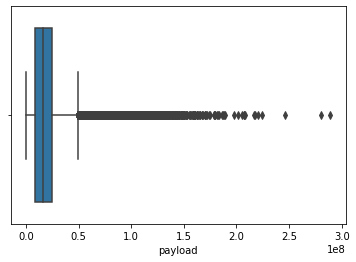

In [61]:
# Checking before-after handling outliers
sns.boxplot(df_ojol_prep['payload'])

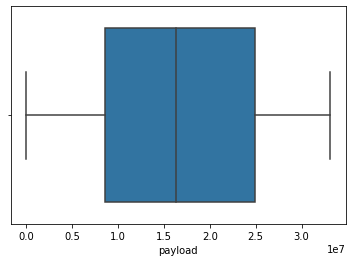

In [62]:
sns.boxplot(df_ojol_prep_outl_clean['payload'])

In [63]:
showCountUniqueVariable(df_ojol_prep_outl_clean)

              Column_Name  Num_Unique Data_Type
19  total_recharge_mytsel           1   float64
5          rev_voice_pack           1   float64
6            rev_sms_pack           1   float64
8         rev_pack_mytsel           1   float64
0         mytsel_app_user           2  category
21             flag_taker           2  category
17         trx_sms_offnet           4   float64
25           segment_arpu           5  category
26              los_range           7  category
20                 region          13  category
16          trx_sms_onnet          13   float64
23    first_rank_category          15  category
15                trx_sms          17   float64
14       mou_voice_offnet          35   float64
11       trx_voice_offnet          42   float64
10        trx_voice_onnet         144   float64
9               trx_voice         193   float64
3                 rev_sms         196   float64
24         total_recharge         203   float64
13        mou_voice_onnet         223   

(-61.875, 1299.375, 0.5, -0.5)

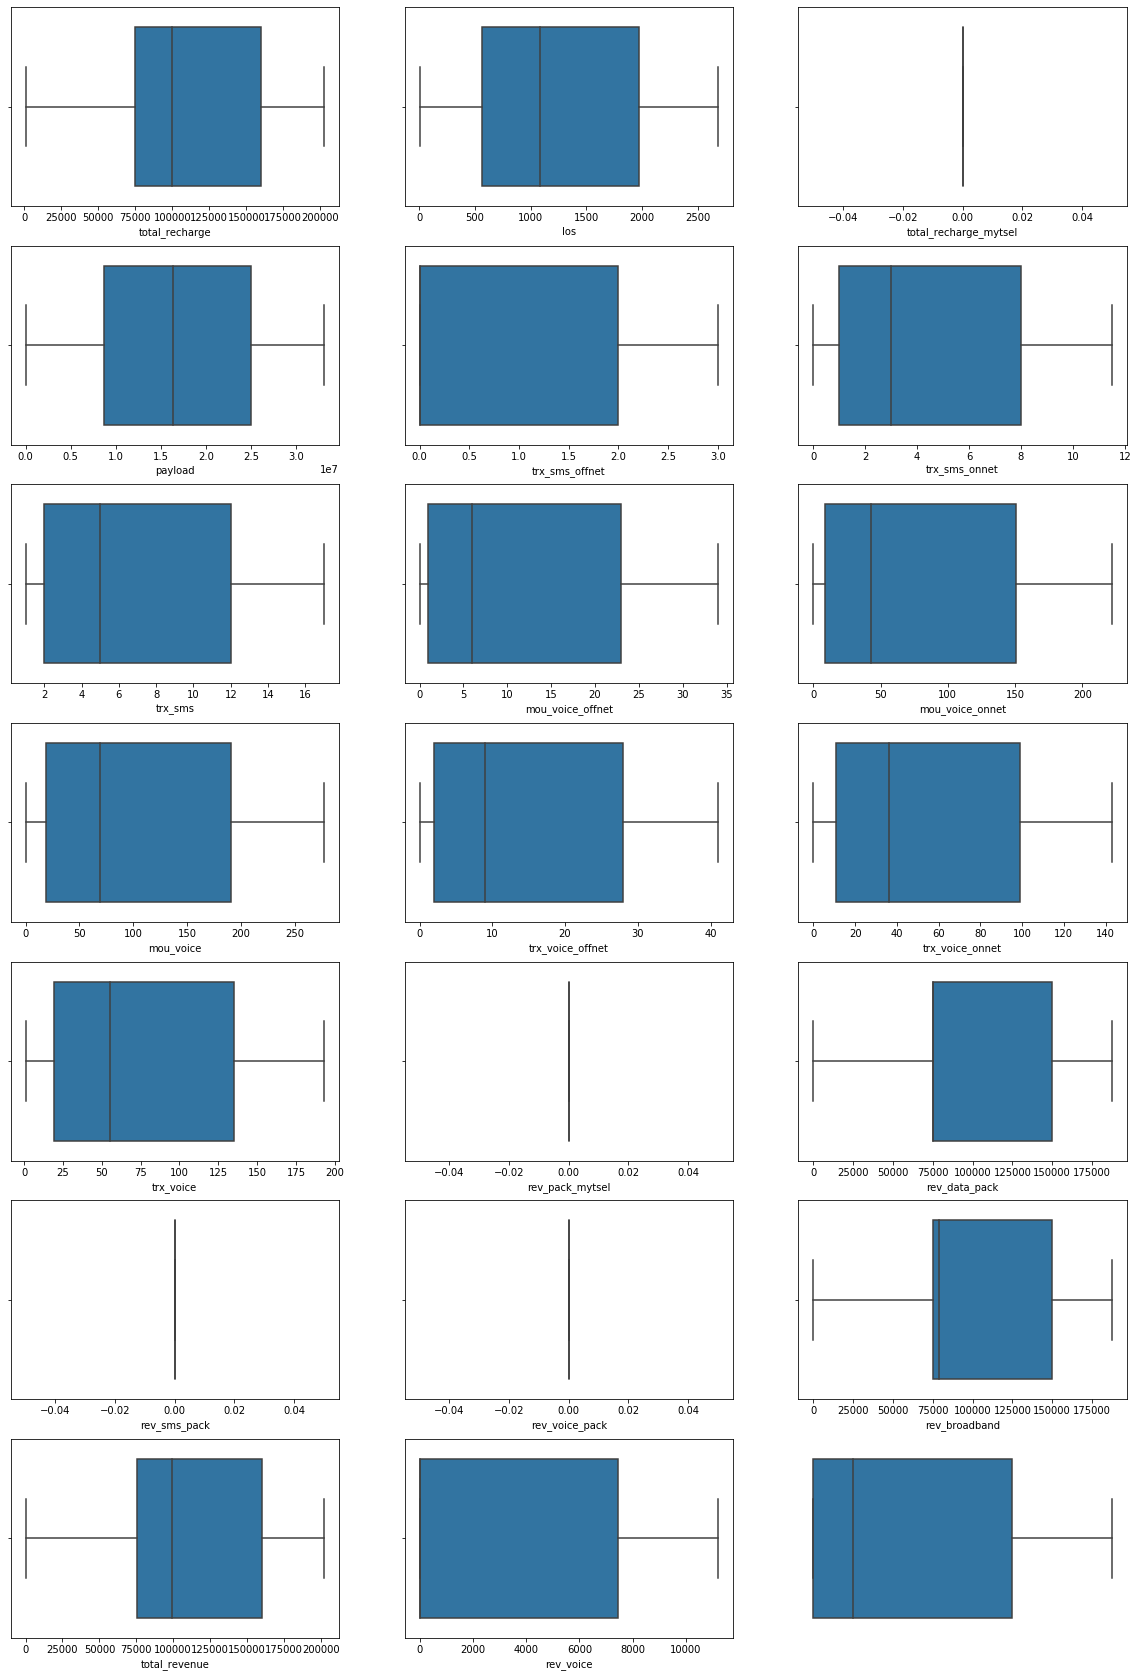

In [64]:
# add by kobud
# Edited by Amal: col_num -> col_type['col_num']

a = list(col_type['col_num']).copy()

n_col = 3
n_row = np.ceil(len(a)/n_col).astype('int')
b = convertColList(a, n_col)

# print(len(a))

n = 0
fig, axarr = plt.subplots(n_row, n_col, figsize=(20, 30))
for i in b:
    m = 0
    for j in i:
        if j in col_type['col_num']:
            sns.boxplot(y=j, data = df_ojol_prep_outl_clean , ax=axarr[n][m], orient='h')

        m = m + 1
    n = n + 1

axarr[(n_row-1), 2].axis('off')

### Cleaning data process after handling outliers (part 2)

#### Drop features that only have 1 unique value

In [65]:
#Added by Amal
print("{} rows x {} columns".format(df_ojol_prep_outl_clean.shape[0], df_ojol_prep_outl_clean.shape[1]))

#Must be 27 columns

695597 rows x 27 columns


In [66]:
#Edited by Amal

#List all columns which contains only '0'
df_ojol_prep_outl_clean.loc[:, (df_ojol_prep_outl_clean != 0).any(axis=0)].columns

Index(['mytsel_app_user', 'total_revenue', 'rev_voice', 'rev_sms',
       'rev_broadband', 'rev_data_pack', 'trx_voice', 'trx_voice_onnet',
       'trx_voice_offnet', 'mou_voice', 'mou_voice_onnet', 'mou_voice_offnet',
       'trx_sms', 'trx_sms_onnet', 'trx_sms_offnet', 'payload', 'region',
       'flag_taker', 'los', 'first_rank_category', 'total_recharge',
       'segment_arpu', 'los_range'],
      dtype='object')

In [67]:
df_ojol_prep_outl_clean=df_ojol_prep_outl_clean.loc[:, (df_ojol_prep_outl_clean!=0).any(axis=0)]

#This process removes total_recharge_mytsel, rev_voice_pack, rev_sms_pack, rev_pack_mytsel columns

In [68]:
#Added by Amal
print("{} rows x {} columns".format(df_ojol_prep_outl_clean.shape[0], df_ojol_prep_outl_clean.shape[1]))

#Must be 23 columns

695597 rows x 23 columns


In [69]:
showCountUniqueVariable(df_ojol_prep_outl_clean)

            Column_Name  Num_Unique Data_Type
0       mytsel_app_user           2  category
17           flag_taker           2  category
14       trx_sms_offnet           4   float64
21         segment_arpu           5  category
22            los_range           7  category
13        trx_sms_onnet          13   float64
16               region          13  category
19  first_rank_category          15  category
12              trx_sms          17   float64
11     mou_voice_offnet          35   float64
8      trx_voice_offnet          42   float64
7       trx_voice_onnet         144   float64
6             trx_voice         193   float64
3               rev_sms         196   float64
20       total_recharge         203   float64
10      mou_voice_onnet         223   float64
9             mou_voice         278   float64
18                  los        2680   float64
5         rev_data_pack        3127   float64
2             rev_voice       11070   float64
4         rev_broadband      10318

#### Redefining categorical and numerical data type

In [70]:
# add by kobud

df_ojol_prep_outl_clean = convertToCategoryType(df_ojol_prep_outl_clean, 16)

# pengecualian untuk 2 var trx, non categorical
col_except_cat = ['trx_sms_offnet', 'trx_sms_onnet']
df_ojol_prep_outl_clean[col_except_cat] = df_ojol_prep_outl_clean[col_except_cat].astype('float64')

showCountUniqueVariable(df_ojol_prep_outl_clean)

            Column_Name  Num_Unique Data_Type
0       mytsel_app_user           2  category
17           flag_taker           2  category
14       trx_sms_offnet           4   float64
21         segment_arpu           5  category
22            los_range           7  category
13        trx_sms_onnet          13   float64
16               region          13  category
19  first_rank_category          15  category
12              trx_sms          17   float64
11     mou_voice_offnet          35   float64
8      trx_voice_offnet          42   float64
7       trx_voice_onnet         144   float64
6             trx_voice         193   float64
3               rev_sms         196   float64
20       total_recharge         203   float64
10      mou_voice_onnet         223   float64
9             mou_voice         278   float64
18                  los        2680   float64
5         rev_data_pack        3127   float64
2             rev_voice       11070   float64
4         rev_broadband      10318

In [71]:
# add by kobud

col_type = defineNumCatCol(df_ojol_prep_outl_clean)
print(col_type)

{'col_num': Index(['total_revenue', 'rev_voice', 'rev_sms', 'rev_broadband',
       'rev_data_pack', 'trx_voice', 'trx_voice_onnet', 'trx_voice_offnet',
       'mou_voice', 'mou_voice_onnet', 'mou_voice_offnet', 'trx_sms',
       'trx_sms_onnet', 'trx_sms_offnet', 'payload', 'los', 'total_recharge'],
      dtype='object'), 'col_cat': Index(['mytsel_app_user', 'region', 'flag_taker', 'first_rank_category',
       'segment_arpu', 'los_range'],
      dtype='object')}


In [72]:
showCountUniqueVariable(df_ojol_prep_outl_clean)

            Column_Name  Num_Unique Data_Type
0       mytsel_app_user           2  category
17           flag_taker           2  category
14       trx_sms_offnet           4   float64
21         segment_arpu           5  category
22            los_range           7  category
13        trx_sms_onnet          13   float64
16               region          13  category
19  first_rank_category          15  category
12              trx_sms          17   float64
11     mou_voice_offnet          35   float64
8      trx_voice_offnet          42   float64
7       trx_voice_onnet         144   float64
6             trx_voice         193   float64
3               rev_sms         196   float64
20       total_recharge         203   float64
10      mou_voice_onnet         223   float64
9             mou_voice         278   float64
18                  los        2680   float64
5         rev_data_pack        3127   float64
2             rev_voice       11070   float64
4         rev_broadband      10318

### EDA Part 2

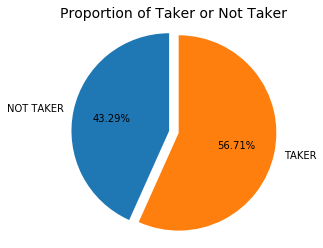

In [73]:
labels = 'NOT TAKER', 'TAKER'
sizes = [df_ojol_prep_outl_clean.flag_taker[df_ojol_prep_outl_clean['flag_taker']==0].count(), 
         df_ojol_prep_outl_clean.flag_taker[df_ojol_prep_outl_clean['flag_taker']==1].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(4, 4))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%',
        startangle=90)
ax1.axis('equal')
plt.title("Proportion of Taker or Not Taker", size=14)
plt.show()

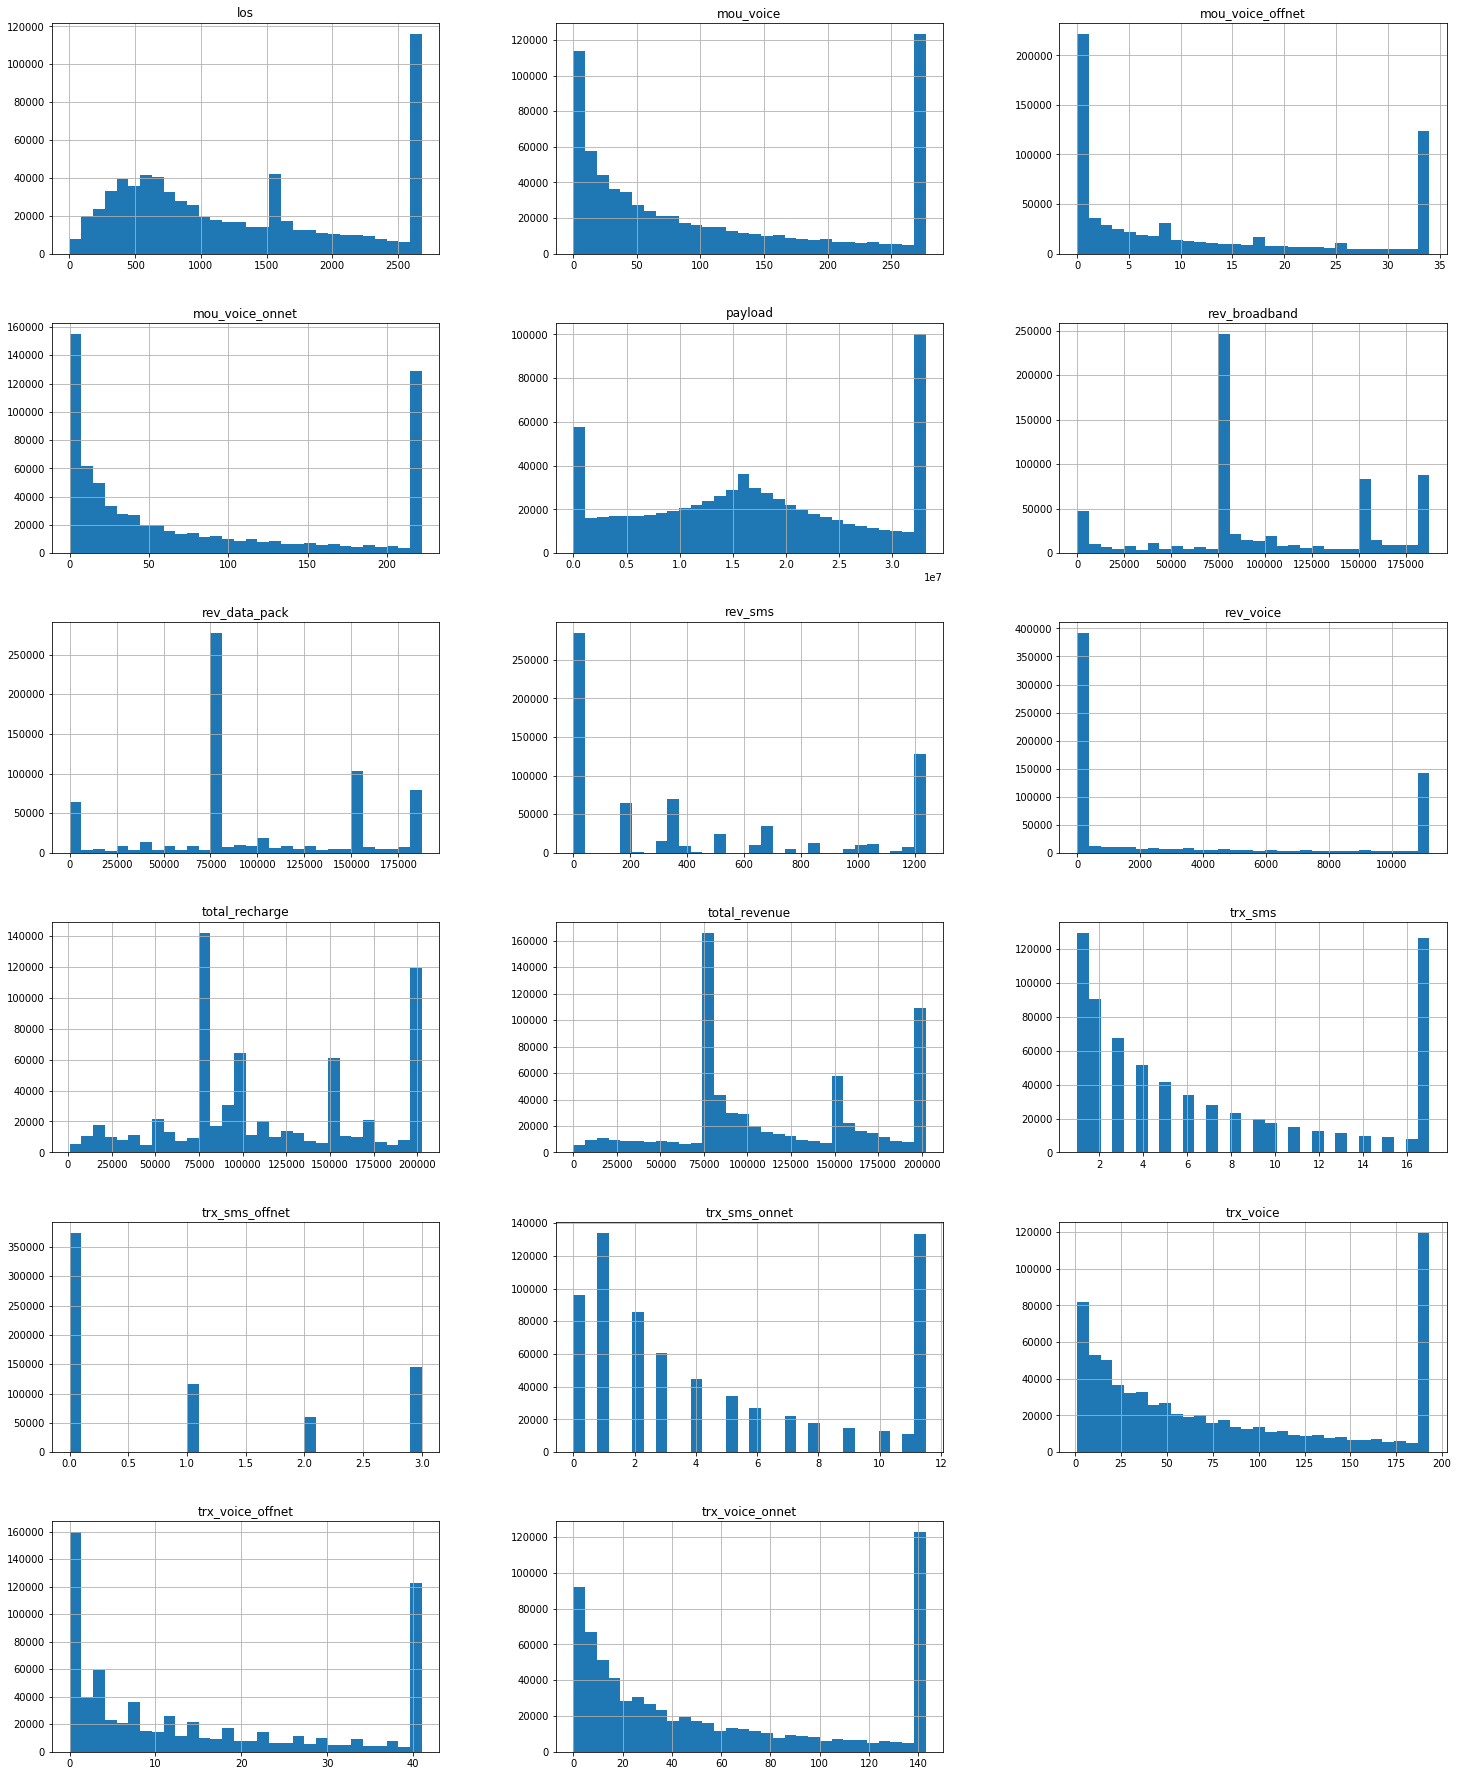

In [74]:
# Checking data distribution
df_ojol_prep_outl_clean.hist(column= col_type['col_num'], 
                             bins=30, figsize=(25, 120), layout=(22, 3));

[]

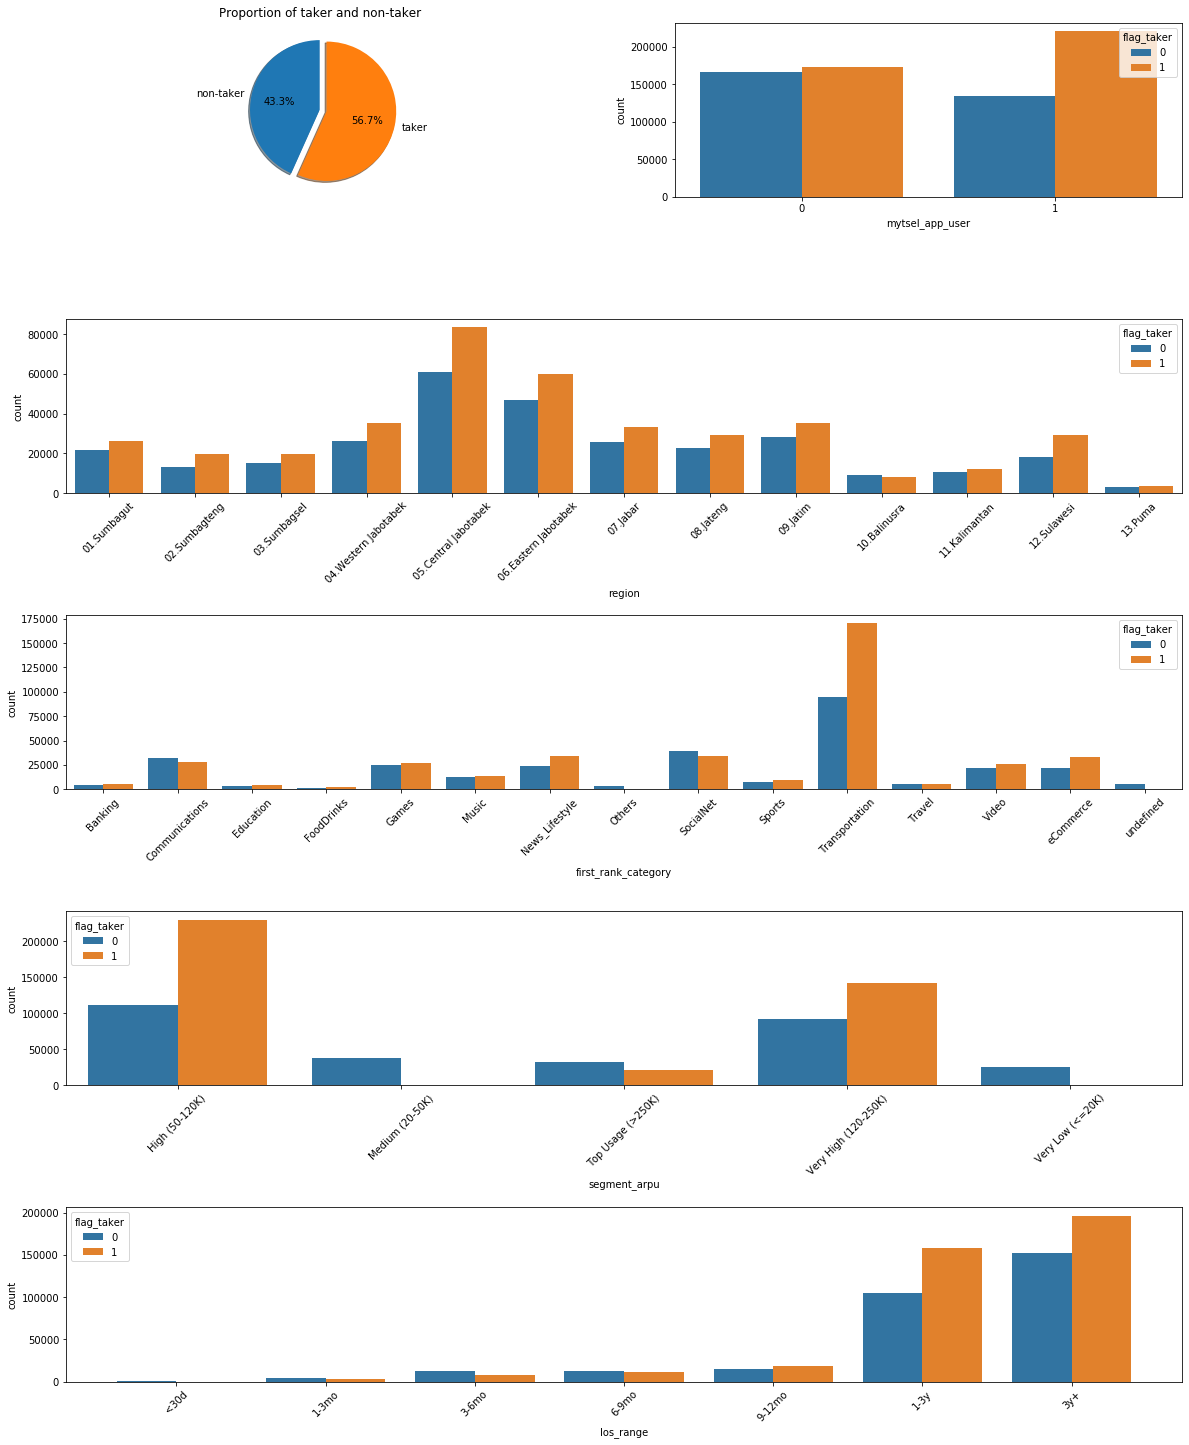

In [75]:
# add by kobud

plt.figure(figsize=(20,25))
ax1 = plt.subplot2grid((5, 2), (0, 0), colspan=1)
ax2 = plt.subplot2grid((5, 2), (0, 1), colspan=1)
ax3 = plt.subplot2grid((5, 2), (1, 0), colspan=2)
ax3.tick_params('x', labelrotation=45)
ax4 = plt.subplot2grid((5, 2), (2, 0), colspan=2)
ax4.tick_params('x', labelrotation=45)
ax5 = plt.subplot2grid((5, 2), (3, 0), colspan=2)
ax5.tick_params('x', labelrotation=45)
ax6 = plt.subplot2grid((5, 2), (4, 0), colspan=2)
ax6.tick_params('x', labelrotation=45)

ax1.set_title('Proportion of taker and non-taker')

labels = 'non-taker', 'taker'
sizes = [df_ojol_prep_outl_clean.flag_taker[df_ojol_prep_outl_clean['flag_taker']==0].count(), 
         df_ojol_prep_outl_clean.flag_taker[df_ojol_prep_outl_clean['flag_taker']==1].count()]
explode = (0, 0.1)
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

sns.countplot(x='mytsel_app_user', hue = 'flag_taker',data = df_ojol_prep_outl_clean, ax=ax2)
sns.countplot(x='region', hue = 'flag_taker',data = df_ojol_prep_outl_clean, ax=ax3)
sns.countplot(x='first_rank_category', hue = 'flag_taker',data = df_ojol_prep_outl_clean, ax=ax4)
sns.countplot(x='segment_arpu', hue = 'flag_taker',data = df_ojol_prep_outl_clean, ax=ax5)
sns.countplot(x='los_range', hue = 'flag_taker',data = df_ojol_prep_outl_clean, ax=ax6)

# plt.margins(0.9)
plt.subplots_adjust(hspace=.7)
plt.plot()


## Feature Engineering

In [76]:
#Added by Amal
print("{} rows x {} columns".format(df_ojol_prep_outl_clean.shape[0], df_ojol_prep_outl_clean.shape[1]))

#Must be 23 columns

695597 rows x 23 columns


In [77]:
# add by kobud
# new var in new process

df_ojol_fe = df_ojol_prep_outl_clean.copy()
showCountUniqueVariable(df_ojol_fe)

            Column_Name  Num_Unique Data_Type
0       mytsel_app_user           2  category
17           flag_taker           2  category
14       trx_sms_offnet           4   float64
21         segment_arpu           5  category
22            los_range           7  category
13        trx_sms_onnet          13   float64
16               region          13  category
19  first_rank_category          15  category
12              trx_sms          17   float64
11     mou_voice_offnet          35   float64
8      trx_voice_offnet          42   float64
7       trx_voice_onnet         144   float64
6             trx_voice         193   float64
3               rev_sms         196   float64
20       total_recharge         203   float64
10      mou_voice_onnet         223   float64
9             mou_voice         278   float64
18                  los        2680   float64
5         rev_data_pack        3127   float64
2             rev_voice       11070   float64
4         rev_broadband      10318

In [78]:
# Added by Agies+Amal
# edited by kobud
# Ratio revenue per service (voice/sms/broadband) terhadap total revenue
df_ojol_fe['rev_voice_ratio'] = df_ojol_fe['rev_voice']/df_ojol_fe['total_revenue']
df_ojol_fe['rev_voice_ratio'] = df_ojol_fe['rev_voice_ratio'].fillna(value=0)

df_ojol_fe['rev_sms_ratio'] = df_ojol_fe['rev_sms']/df_ojol_fe['total_revenue']
df_ojol_fe['rev_sms_ratio'] = df_ojol_fe['rev_sms_ratio'].fillna(value=0)

df_ojol_fe['rev_broadband_ratio'] = df_ojol_fe['rev_broadband']/df_ojol_fe['total_revenue']
df_ojol_fe['rev_broadband_ratio'] = df_ojol_fe['rev_broadband_ratio'].fillna(value=0)

#########################################################################
# Ratio trx voice onnet atau offnet terhadap total trx voice secara menyeluruh
df_ojol_fe['trx_voice_onnet_ratio'] = df_ojol_fe['trx_voice_onnet']/df_ojol_fe['trx_voice']
df_ojol_fe['trx_voice_onnet_ratio'] = df_ojol_fe['trx_voice_onnet_ratio'].fillna(value=0)

df_ojol_fe['trx_voice_offnet_ratio'] = df_ojol_fe['trx_voice_offnet']/df_ojol_fe['trx_voice']
df_ojol_fe['trx_voice_offnet_ratio'] = df_ojol_fe['trx_voice_offnet_ratio'].fillna(value=0)

#########################################################################
# Ratio trx sms onnet atau offnet terhadap total trx sms secara menyeluruh
df_ojol_fe['trx_sms_onnet_ratio'] = df_ojol_fe['trx_sms_onnet']/df_ojol_fe['trx_sms']
df_ojol_fe['trx_sms_onnet_ratio'] = df_ojol_fe['trx_sms_onnet_ratio'].fillna(value=0)

df_ojol_fe['trx_sms_offnet_ratio'] = df_ojol_fe['trx_sms_offnet']/df_ojol_fe['trx_sms']
df_ojol_fe['trx_sms_offnet_ratio'] = df_ojol_fe['trx_sms_offnet_ratio'].fillna(value=0)

#########################################################################
df_ojol_fe['mou_voice_onnet_ratio'] = df_ojol_fe['mou_voice_onnet']/df_ojol_fe['mou_voice']
df_ojol_fe['mou_voice_onnet_ratio'] = df_ojol_fe['mou_voice_onnet_ratio'].fillna(value=0)

df_ojol_fe['mou_voice_offnet_ratio'] = df_ojol_fe['mou_voice_offnet']/df_ojol_fe['mou_voice']
df_ojol_fe['mou_voice_offnet_ratio'] = df_ojol_fe['mou_voice_offnet_ratio'].fillna(value=0)

#########################################################################
df_ojol_fe['recharge_revenue_ratio'] = df_ojol_fe['total_recharge']/df_ojol_fe['total_revenue']
df_ojol_fe['recharge_revenue_ratio'] = df_ojol_fe['recharge_revenue_ratio'].fillna(value=0)

#########################################################################
df_ojol_fe['average_rev_voice_per_trx'] = (df_ojol_fe['rev_voice'])/df_ojol_fe['trx_voice']
df_ojol_fe['average_rev_voice_per_trx'] = df_ojol_fe['average_rev_voice_per_trx'].fillna(value=0)

df_ojol_fe['average_mou_voice_per_trx'] = (df_ojol_fe['mou_voice'])/df_ojol_fe['trx_voice']
df_ojol_fe['average_mou_voice_per_trx'] = df_ojol_fe['average_mou_voice_per_trx'].fillna(value=0)

#########################################################################
df_ojol_fe['average_rev_sms_per_trx'] = (df_ojol_fe['rev_sms'])/df_ojol_fe['trx_sms']
df_ojol_fe['average_rev_sms_per_trx'] = df_ojol_fe['average_rev_sms_per_trx'].fillna(value=0)

#########################################################################
df_ojol_fe['average_rev_data_per_trx'] = (df_ojol_fe['rev_broadband'])/df_ojol_fe['payload']
df_ojol_fe['average_rev_data_per_trx'] = df_ojol_fe['average_rev_data_per_trx'].fillna(value=0)

In [79]:
#Added by Amal
print("{} rows x {} columns".format(df_ojol_fe.shape[0], df_ojol_fe.shape[1]))

#Must be 37 columns

695597 rows x 37 columns


In [80]:
showCountUniqueVariable(df_ojol_fe)

                  Column_Name  Num_Unique Data_Type
0             mytsel_app_user           2  category
17                 flag_taker           2  category
14             trx_sms_offnet           4   float64
21               segment_arpu           5  category
22                  los_range           7  category
16                     region          13  category
13              trx_sms_onnet          13   float64
19        first_rank_category          15  category
12                    trx_sms          17   float64
11           mou_voice_offnet          35   float64
29       trx_sms_offnet_ratio          36   float64
8            trx_voice_offnet          42   float64
28        trx_sms_onnet_ratio          92   float64
7             trx_voice_onnet         144   float64
6                   trx_voice         193   float64
3                     rev_sms         196   float64
20             total_recharge         203   float64
10            mou_voice_onnet         223   float64
9           

## Converting Categorical Data to Numerical

### Using One Hot Encoding (OHE)

In [81]:
#Added by Amal
print("{} rows x {} columns".format(df_ojol_fe.shape[0], df_ojol_fe.shape[1]))

#Must be 37 columns

695597 rows x 37 columns


In [82]:
# Added by Kobud
# OHE with dummies
# Edited by Amal: adding 'drop_first=True' on get_dummies()

df_ojol_fe_ohe=pd.get_dummies(df_ojol_fe, 
                           prefix=['mytsel_appuser', 'segment_arpu', 'los_range', 'reg', 'first_rank_cat'], 
                           columns=['mytsel_app_user', 'segment_arpu', 'los_range', 'region', 'first_rank_category'], 
                           drop_first=True).copy()

df_ojol_fe_ohe['flag_taker']=df_ojol_fe_ohe['flag_taker'].astype('int64')
df_ojol_fe_ohe=dependentToEndCol(df_ojol_fe_ohe,'flag_taker')

df_ojol_fe_ohe.columns = map(str.lower, df_ojol_fe_ohe.columns) #lowercase
df_ojol_fe_ohe.head()

total_revenue  rev_voice  rev_sms  rev_broadband  rev_data_pack  trx_voice  \
0          10092       8132      800              0              0         25   
1         133657      11200     1238              0              0        186   
2          30006      11200     1238              0              0         36   
3          44503       7133      200              0              0         22   
4           5073       4473      600              0              0        116   

   trx_voice_onnet  trx_voice_offnet  mou_voice  mou_voice_onnet  ...  \
0               12                12          6                2  ...   
1              120                41        102               63  ...   
2                8                28         21                4  ...   
3               15                 7         21               17  ...   
4              116                 0        147              147  ...   

   first_rank_cat_news_lifestyle  first_rank_cat_others  \
0                              0                      0   
1                              0                      0   
2                              0                      0   
3                              0                      0   
4                              0                      0   

   first_rank_cat_socialnet  first_rank_cat_sports  \
0                         0                      0   
1                         0                      0   
2                         0                      0   
3                         0                      0   
4                         0                      0   

   first_rank_cat_transportation  first_rank_cat_travel  first_rank_cat_video  \
0                              1                      0                     0   
1                              1                      0                     0   
2                              1                      0                     0   
3                              0                      0                     0   
4                              1                      0                     0   

   first_rank_cat_ecommerce  first_rank_cat_undefined  flag_taker  
0                         0                         0           0  
1                         0                         0           0  
2                         0                         0           0  
3                         0                         0           0  
4                         0                         0           0  

[5 rows x 69 columns]

In [83]:
#Added by Amal
print("{} rows x {} columns".format(df_ojol_fe_ohe.shape[0], df_ojol_fe_ohe.shape[1]))

#Must be 69 columns

695597 rows x 69 columns


In [84]:
showCountUniqueVariable(df_ojol_fe_ohe)

                          Column_Name  Num_Unique Data_Type
34  segment_arpu_very high (120-250k)           2     uint8
36                    los_range_1-3mo           2     uint8
37                    los_range_3-6mo           2     uint8
38                    los_range_6-9mo           2     uint8
39                   los_range_9-12mo           2     uint8
40                     los_range_1-3y           2     uint8
41                      los_range_3y+           2     uint8
42                  reg_02.sumbagteng           2     uint8
43                   reg_03.sumbagsel           2     uint8
44           reg_04.western jabotabek           2     uint8
45           reg_05.central jabotabek           2     uint8
46           reg_06.eastern jabotabek           2     uint8
47                       reg_07.jabar           2     uint8
48                      reg_08.jateng           2     uint8
49                       reg_09.jatim           2     uint8
50                   reg_10.balinusra   

## Feature Scaling

In [85]:
# Edited by Amal: df_ojol_fe -> df_ojol_fe_ohe

# from mlxtend.preprocessing import minmax_scaling
# pd.options.display.float_format = "{:.2f}".format

# df_ojol_scaled = minmax_scaling(df_ojol_fe_ohe, columns=df_ojol_fe_ohe.columns).copy()

# display(df_ojol_fe_ohe.head())
# display(df_ojol_scaled.head())

## Feature Selection

In [86]:
#Edited by Amal: df_ojol_scaled --> df_ojol_fe_ohe

df_ojol_fs = df_ojol_fe_ohe.copy()

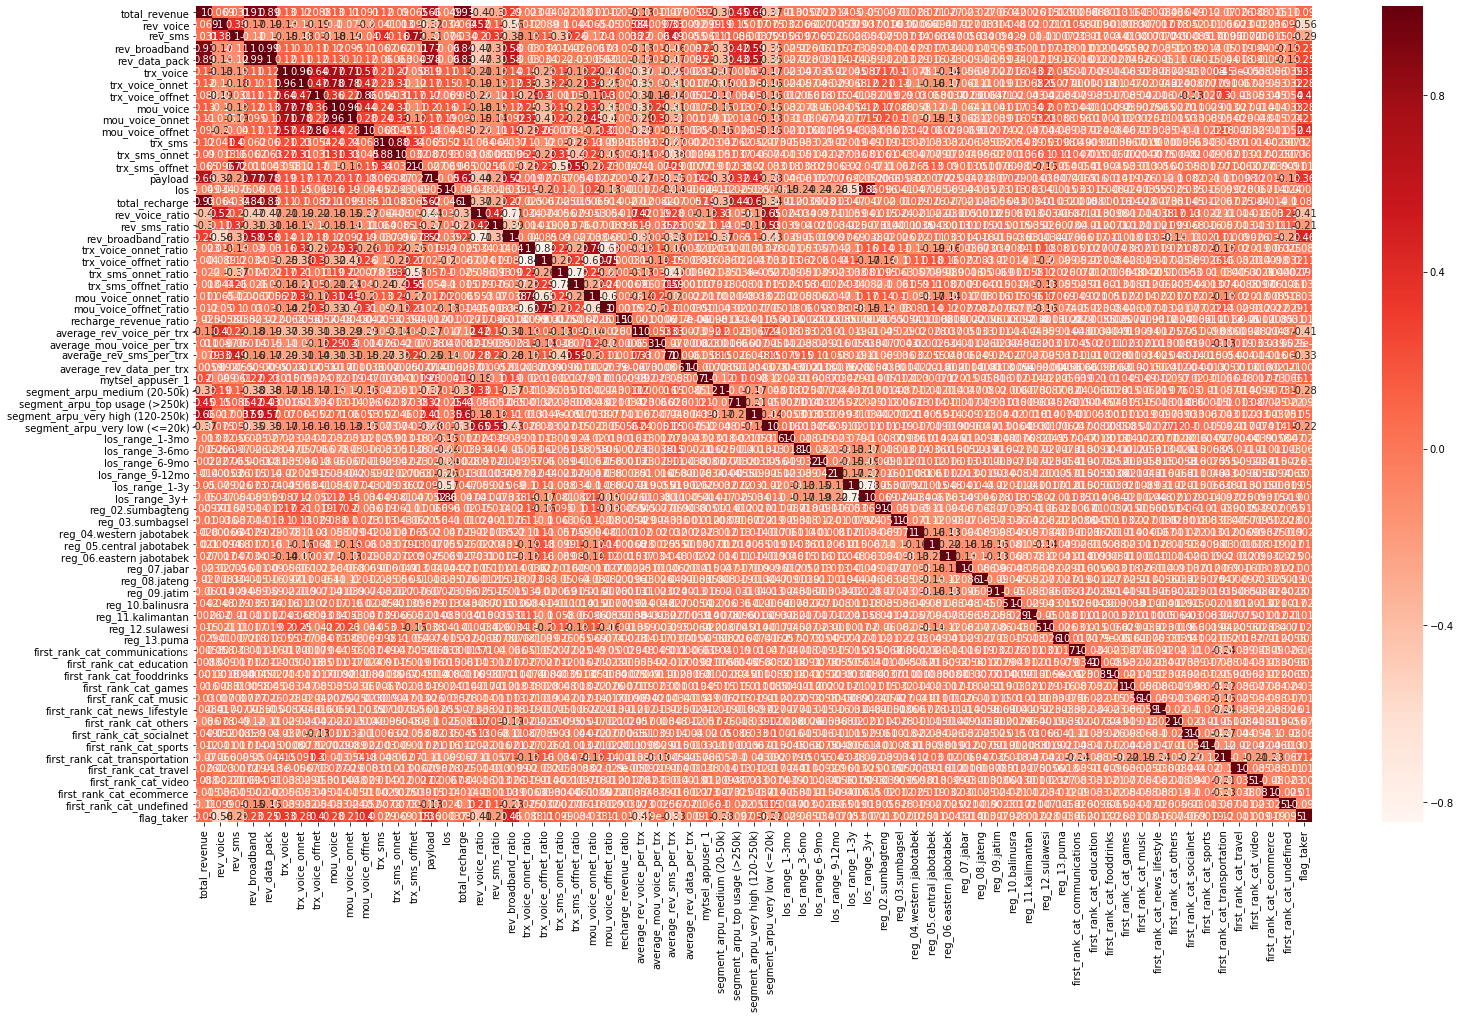

In [87]:
#FILTER METHOD
#Using Pearson Correlation
plt.figure(figsize=(25,15))
cor = df_ojol_fs.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [88]:
#Correlation with output variable
cor_target = abs(cor["flag_taker"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.05]
relevant_features

total_revenue                       0
rev_voice                           1
rev_sms                             0
rev_broadband                       0
rev_data_pack                       0
trx_voice                           0
trx_voice_onnet                     0
trx_voice_offnet                    0
mou_voice                           0
mou_voice_onnet                     0
mou_voice_offnet                    0
trx_sms_onnet                       0
payload                             0
total_recharge                      0
rev_voice_ratio                     0
rev_sms_ratio                       0
rev_broadband_ratio                 0
trx_voice_onnet_ratio               0
trx_voice_offnet_ratio              0
trx_sms_onnet_ratio                 0
mou_voice_offnet_ratio              0
average_rev_voice_per_trx           0
average_rev_sms_per_trx             0
mytsel_appuser_1                    0
segment_arpu_medium (20-50k)        0
segment_arpu_top usage (>250k)      0
segment_arpu

In [89]:
columns = relevant_features.index 
columns.to_frame(index=False)

0
0                       total_revenue
1                           rev_voice
2                             rev_sms
3                       rev_broadband
4                       rev_data_pack
5                           trx_voice
6                     trx_voice_onnet
7                    trx_voice_offnet
8                           mou_voice
9                     mou_voice_onnet
10                   mou_voice_offnet
11                      trx_sms_onnet
12                            payload
13                     total_recharge
14                    rev_voice_ratio
15                      rev_sms_ratio
16                rev_broadband_ratio
17              trx_voice_onnet_ratio
18             trx_voice_offnet_ratio
19                trx_sms_onnet_ratio
20             mou_voice_offnet_ratio
21          average_rev_voice_per_trx
22            average_rev_sms_per_trx
23                   mytsel_appuser_1
24       segment_arpu_medium (20-50k)
25     segment_arpu_top usage (>250k)
26  segment_arpu_very high (120-250k)
27      segment_arpu_very low (<=20k)
28                    los_range_3-6mo
29                     los_range_1-3y
30      first_rank_cat_communications
31              first_rank_cat_others
32           first_rank_cat_socialnet
33      first_rank_cat_transportation
34           first_rank_cat_undefined
35                         flag_taker

In [90]:
#Added by Amal

df_ojol_fs=df_ojol_fs[columns]

print("{} rows x {} columns".format(df_ojol_fs.shape[0], df_ojol_fs.shape[1]))

#Must be 36 (corr>0.05) columns

695597 rows x 36 columns


In [91]:
df_ojol_fs.columns

Index(['total_revenue', 'rev_voice', 'rev_sms', 'rev_broadband',
       'rev_data_pack', 'trx_voice', 'trx_voice_onnet', 'trx_voice_offnet',
       'mou_voice', 'mou_voice_onnet', 'mou_voice_offnet', 'trx_sms_onnet',
       'payload', 'total_recharge', 'rev_voice_ratio', 'rev_sms_ratio',
       'rev_broadband_ratio', 'trx_voice_onnet_ratio',
       'trx_voice_offnet_ratio', 'trx_sms_onnet_ratio',
       'mou_voice_offnet_ratio', 'average_rev_voice_per_trx',
       'average_rev_sms_per_trx', 'mytsel_appuser_1',
       'segment_arpu_medium (20-50k)', 'segment_arpu_top usage (>250k)',
       'segment_arpu_very high (120-250k)', 'segment_arpu_very low (<=20k)',
       'los_range_3-6mo', 'los_range_1-3y', 'first_rank_cat_communications',
       'first_rank_cat_others', 'first_rank_cat_socialnet',
       'first_rank_cat_transportation', 'first_rank_cat_undefined',
       'flag_taker'],
      dtype='object')

# MODELING

## Split Data

In [92]:
#To avoid the 'los' feature is removed
df_ojol_fs=df_ojol_fe_ohe[['total_revenue', 'rev_voice', 'rev_sms', 'rev_broadband',
       'rev_data_pack', 'trx_voice', 'trx_voice_onnet', 'trx_voice_offnet',
       'mou_voice', 'mou_voice_onnet', 'mou_voice_offnet', 'trx_sms_onnet',
       'payload', 'total_recharge', 'rev_voice_ratio', 'rev_sms_ratio',
       'rev_broadband_ratio', 'trx_voice_onnet_ratio',
       'trx_voice_offnet_ratio', 'trx_sms_onnet_ratio',
       'mou_voice_offnet_ratio', 'average_rev_voice_per_trx',
       'average_rev_sms_per_trx', 'mytsel_appuser_1',
       'segment_arpu_medium (20-50k)', 'segment_arpu_top usage (>250k)',
       'segment_arpu_very high (120-250k)', 'segment_arpu_very low (<=20k)',
       'los_range_3-6mo', 'los_range_1-3y', 'first_rank_cat_communications',
       'first_rank_cat_others', 'first_rank_cat_socialnet',
       'first_rank_cat_transportation', 'first_rank_cat_undefined','los',
       'flag_taker']]

In [93]:
#Added by Amal

print("{} rows x {} columns".format(df_ojol_fs.shape[0], df_ojol_fs.shape[1]))

#Must be 37 columns

695597 rows x 37 columns


In [94]:
#Edited by Amal: df_ojol_scaled -> df_ojol_fe_ohe
from sklearn.model_selection import train_test_split
      
y = df_ojol_fs.iloc[:,-1] #all columns except the last one
x = df_ojol_fs.iloc[:,:len(df_ojol_fs.columns)-1] #only the last column

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 10)

x_train_lim = x_train.iloc[:10000,:].copy()
y_train_lim = y_train.iloc[:10000].copy()
x_test_lim = x_test.iloc[:10000,:].copy()
y_test_lim = x_test.iloc[:10000].copy()

## Cross Validation Multi Model

In [95]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

In [96]:
logr = LogisticRegression()
svc = SVC()
gnb = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=10)
dc_reg = DecisionTreeRegressor()
dc_clas = DecisionTreeClassifier()
random_fc = RandomForestClassifier(n_estimators = 10)
km = KMeans()

In [97]:
print(cross_val_score(logr, x_train_lim, y_train_lim, cv=5, scoring='accuracy').mean())
print(cross_val_score(svc, x_train_lim, y_train_lim, cv=5, scoring='accuracy').mean())
print(cross_val_score(gnb, x_train_lim, y_train_lim, cv=5, scoring='accuracy').mean()) 
print(cross_val_score(knn, x_train_lim, y_train_lim, cv=5, scoring='accuracy').mean()) 
print(cross_val_score(dc_reg, x_train_lim, y_train_lim, cv=5, scoring='accuracy').mean())
print(cross_val_score(dc_clas, x_train_lim, y_train_lim, cv=5, scoring='accuracy').mean()) 
print(cross_val_score(random_fc, x_train_lim, y_train_lim, cv=5, scoring='accuracy').mean())  
print(cross_val_score(km, x_train_lim, y_train_lim, cv=5, scoring='accuracy').mean())  

0.7948999999999999
0.7029
0.817
0.7433
0.8265
0.8257
0.8701000000000001
0.11229999999999998


## Modeling

In [98]:
from sklearn.ensemble import RandomForestClassifier

modelC = RandomForestClassifier(random_state=0, n_estimators=500, max_depth=1)
# modelC = RandomForestClassifier()
modelC.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

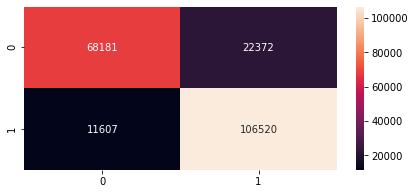

In [99]:
from sklearn.metrics import confusion_matrix
y_predict = modelC.predict(x_test)
cm = confusion_matrix(y_test, y_predict)
fig, ax = plt.subplots(figsize=(7,3))
sns.heatmap(cm, annot=True, fmt="d")

In [100]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.85      0.75      0.80     90553
           1       0.83      0.90      0.86    118127

    accuracy                           0.84    208680
   macro avg       0.84      0.83      0.83    208680
weighted avg       0.84      0.84      0.84    208680



In [101]:
from sklearn.metrics import roc_curve, auc

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predict)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8273408066021032

## Modeling with Feature Selection

reference link : 
https://www.kaggle.com/kanncaa1/feature-selection-and-data-visualization

### Univariate Feature Selection

In [102]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2
# # find best scored 5 features
# select_feature = SelectKBest(chi2, k=15).fit(x_train, y_train)

In [103]:
# print('Score list:', select_feature.scores_)
# print('Feature list:', x_train.columns)

In [104]:
# from sklearn.metrics import accuracy_score

# x_train_uv = select_feature.transform(x_train).copy()
# x_test_uv = select_feature.transform(x_test).copy()
# #random forest classifier with n_estimators=10 (default)
# modelC_uv = RandomForestClassifier()
# #modelC_uv = RandomForestClassifier(random_state=0, n_estimators=500, max_depth=1)
# fit_uv = modelC_uv.fit(x_train_uv ,y_train)
# ac_uv = accuracy_score(y_test, modelC_uv.predict(x_test_uv))
# print('Accuracy is: ',ac_uv)
# cm_uv = confusion_matrix(y_test, modelC_uv.predict(x_test_uv))

# fig, ax = plt.subplots(figsize=(7,3))
# sns.heatmap(cm_uv, annot=True, fmt="d")

In [105]:
# from sklearn.metrics import classification_report
# print(classification_report(y_test, modelC_uv.predict(x_test_uv)))

### Recursive Feature Elimination (RFE)

In [106]:
# from sklearn.feature_selection import RFE
# # Create the RFE object and rank each pixel
# modelC_rfe = RandomForestClassifier()
# # modelC_rfe = RandomForestClassifier(random_state=0, n_estimators=500, max_depth=1)
# rfe = RFE(estimator = modelC_rfe, n_features_to_select=15, step=1)
# rfe = rfe.fit(x_train, y_train)

In [107]:
# print('Chosen best 15 feature by rfe:',x_train.columns[rfe.support_])

In [108]:
# ac_rfe = accuracy_score(y_test, rfe.predict(x_test))
# print('Accuracy is: ',ac_rfe)
# cm_rfe = confusion_matrix(y_test, rfe.predict(x_test))

# fig, ax = plt.subplots(figsize=(7,3))
# sns.heatmap(cm_rfe ,annot=True,fmt="d")

In [109]:
# print(classification_report(y_test, rfe.predict(x_test)))

### Recursive Feature Elimination (RFE) with Cross Validation

In [110]:
# display(len(x_train.columns))

In [111]:
# from sklearn.feature_selection import RFECV

# # The "accuracy" scoring is proportional to the number of correct classifications
# clf_rf_4 = RandomForestClassifier(random_state=0, n_estimators=500, max_depth=1) 
# rfecv = RFECV(estimator=clf_rf_4, step=1, cv=5,scoring='accuracy')   #5-fold cross-validation
# rfecv = rfecv.fit(x_train, y_train)

# print('Optimal number of features :', rfecv.n_features_)
# print('Best features :', x_train.columns[rfecv.support_])

In [112]:
# # Plot number of features VS. cross-validation scores

# fig, ax = plt.subplots(figsize=(7,5))
# # plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score of number of selected features")
# plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
# plt.show()

In [113]:
# from sklearn.metrics import accuracy_score

# ac_4 = accuracy_score(y_test, rfecv.predict(x_test))
# print('Accuracy is: ',ac_4)
# cm_4 = confusion_matrix(y_test, rfecv.predict(x_test))

# fig, ax = plt.subplots(figsize=(7,3))
# sns.heatmap(cm_4,annot=True,fmt="d")

In [114]:
# print(classification_report(y_test, rfecv.predict(x_test)))

## Hyperparameter Tuning

In [115]:
# import numpy as np 
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import cross_val_score

# random_search = {'criterion': ['entropy', 'gini'],
#                'max_depth': list(np.linspace(10, 1200, 10, dtype = int)) + [None],
#                'max_features': ['auto', 'sqrt','log2', None],
#                'min_samples_leaf': [4, 6, 8, 12],
#                'min_samples_split': [5, 7, 10, 14],
#                'n_estimators': list(np.linspace(151, 1200, 10, dtype = int))}

# clf = RandomForestClassifier()
# model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 80, 
#                                cv = 4, verbose= 5, random_state= 101, n_jobs = -1)
# model.fit(x_train ,y_train)

In [116]:
# n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
# train_results = []
# test_results = []
# for estimator in n_estimators:
#     rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
#     rf.fit(x_train, y_train)
#     train_pred = rf.predict(x_train)
#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
#     roc_auc = auc(false_positive_rate, true_positive_rate)
#     train_results.append(roc_auc)
#     y_pred = rf.predict(x_test)
#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#     roc_auc = auc(false_positive_rate, true_positive_rate)
#     test_results.append(roc_auc)
    
# from matplotlib.legend_handler import HandlerLine2D
# line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
# line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
# plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
# plt.ylabel('AUC score')
# plt.xlabel('n_estimators')
# plt.show()

In [117]:
# from sklearn.model_selection import RandomizedSearchCV

# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# print(random_grid)
# {'bootstrap': [True, False],
#  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [118]:
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rfg = RandomForestRegressor()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rfg_random = RandomizedSearchCV(estimator = rfg, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# rfg_random.fit(x_train, y_train)

## Model Interpretability

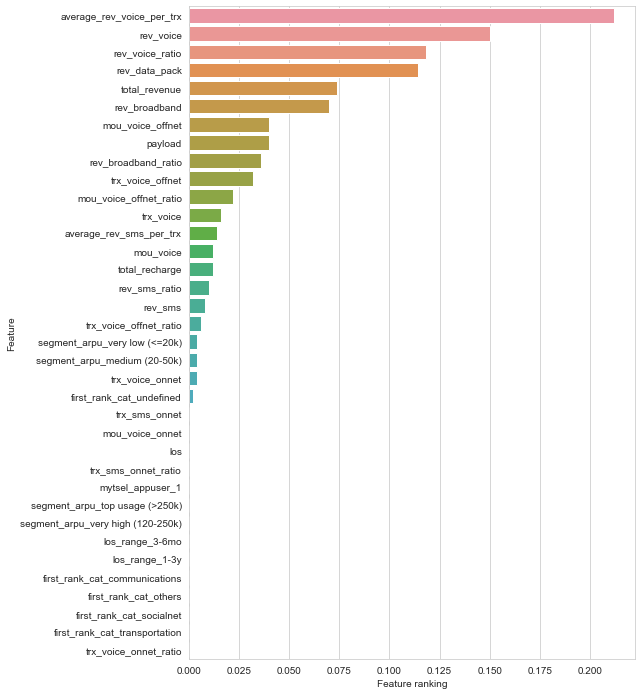

In [119]:
#Edited by Amal -> change the df_ojol_scaled to df_ojol_fs

def plot_importances_features(model, columns):
    indices = np.argsort(model.feature_importances_)[::-1]
    feat_imp = pd.DataFrame({'Feature':columns.values[indices],
                        'Feature ranking':model.feature_importances_[indices]})
    plt.rcParams['figure.figsize']=(8,12)
    sns.set_style('whitegrid')
    ax = sns.barplot(x='Feature ranking', y='Feature', data=feat_imp)
    ax.set(xlabel='Feature ranking')
    plt.show()

plot_importances_features(modelC,df_ojol_fs.columns)

### SHAP Values

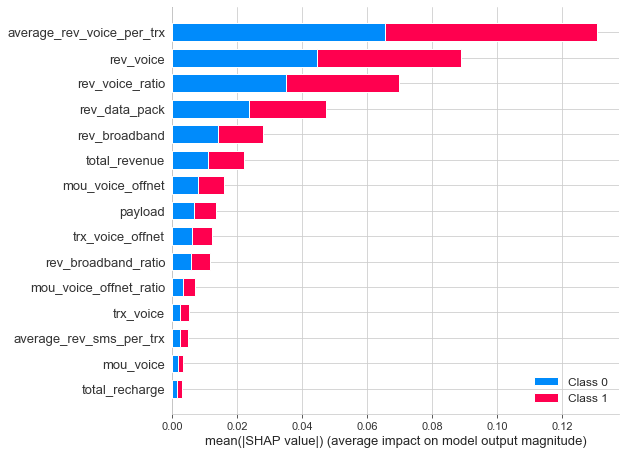

In [120]:
#Edited by Amal -> change the df_ojol_scaled to df_ojol_fs

shap_values = shap.TreeExplainer(modelC).shap_values(df_ojol_fs)
shap.summary_plot(shap_values, df_ojol_fs, plot_type="bar", max_display = 15)

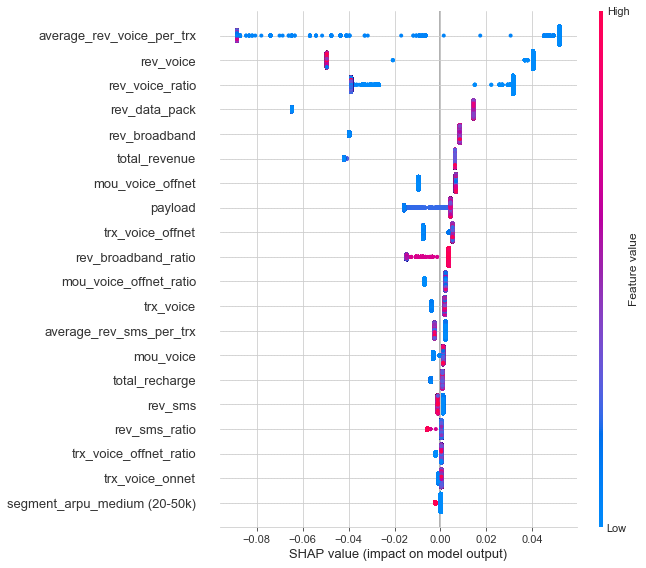

In [121]:
#Edited by Amal -> change the df_ojol_scaled to df_ojol_fs

explainer = shap.TreeExplainer(modelC)
shap_values = explainer.shap_values(df_ojol_fs)
shap.summary_plot(shap_values[1], df_ojol_fs)

In [122]:
#Edited by Amal -> change the df_ojol_scaled to df_ojol_fs

row_to_show = 5
data_for_prediction = df_ojol_fs.iloc[row_to_show]
shap_values = explainer.shap_values(data_for_prediction)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

In [123]:
#Edited by Amal -> change the df_ojol_scaled to df_ojol_fs

row_to_show = 40
data_for_prediction = df_ojol_fs.iloc[row_to_show]
shap_values = explainer.shap_values(data_for_prediction)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

### Lime

In [124]:
import lime
import lime.lime_tabular

In [125]:
#Edited by Amal -> change the df_ojol_scaled to df_ojol_fs
explainer = lime.lime_tabular.LimeTabularExplainer(x_train.values,
                                                   mode='classification',
                                                   training_labels=df_ojol_fs['flag_taker'],
                                                   feature_names= x_train.columns
                                                  )

In [126]:
x.columns

Index(['total_revenue', 'rev_voice', 'rev_sms', 'rev_broadband',
       'rev_data_pack', 'trx_voice', 'trx_voice_onnet', 'trx_voice_offnet',
       'mou_voice', 'mou_voice_onnet', 'mou_voice_offnet', 'trx_sms_onnet',
       'payload', 'total_recharge', 'rev_voice_ratio', 'rev_sms_ratio',
       'rev_broadband_ratio', 'trx_voice_onnet_ratio',
       'trx_voice_offnet_ratio', 'trx_sms_onnet_ratio',
       'mou_voice_offnet_ratio', 'average_rev_voice_per_trx',
       'average_rev_sms_per_trx', 'mytsel_appuser_1',
       'segment_arpu_medium (20-50k)', 'segment_arpu_top usage (>250k)',
       'segment_arpu_very high (120-250k)', 'segment_arpu_very low (<=20k)',
       'los_range_3-6mo', 'los_range_1-3y', 'first_rank_cat_communications',
       'first_rank_cat_others', 'first_rank_cat_socialnet',
       'first_rank_cat_transportation', 'first_rank_cat_undefined', 'los'],
      dtype='object')

In [127]:
#Edited by Amal -> use all columns for feature_names variable

# feature_names = ['rev_voice', 'rev_sms', 'rev_broadband', 'rev_voice_pack',
#         'rev_data_pack', 'rev_pack_mytsel', 'trx_voice', 'trx_voice_onnet',
#         'trx_voice_offnet', 'mou_voice', 'mou_voice_onnet', 'mou_voice_offnet',
#         'payload', 'mytsel_app_user_1', 'first_rank_category_Transportation',
#         'segment_arpu_Medium (20-50K)', 'segment_arpu_Very Low (<=20K)',
#         'rev_voice_ratio', 'rev_sms_ratio', 'rev_broadband_ratio',
#         'trx_voice_offnet_ratio', 'trx_sms_onnet_ratio',
#         'mou_voice_offnet_ratio', 'average_rev_voice_per_trx',
#         'average_rev_sms_per_trx']

feature_names=x.columns.tolist()

In [128]:
class_names = ['Non Taker','Taker']
explainerL = lime.lime_tabular.LimeTabularExplainer(x_train.values, 
feature_names=feature_names, class_names=class_names, discretize_continuous=True)

expL = explainerL.explain_instance(x_test.iloc[50],modelC.predict_proba,num_features=25,top_labels=1)

expL.show_in_notebook(show_table=True, show_all=False)

### ELI5

In [129]:
import eli5

In [130]:
eli5.show_weights(modelC,feature_names=feature_names,target_names=class_names)
eli5.show_prediction(modelC, x_test.iloc[50],feature_names=feature_names,target_names=class_names)

## Modeling Results

### Predict data flag_taker 0

In [131]:
# edit by kobud
# data from feature engineering
#Edited by Amal -> change the df_ojol_scaled to df_ojol_fs

df_ojol_modeling = df_ojol_fs[df_ojol_fs['flag_taker']==0].copy()
display(df_ojol_modeling.shape)
display(df_ojol_modeling.head(10))

(301156, 37)

total_revenue  rev_voice  rev_sms  rev_broadband  rev_data_pack  \
0           10092       8132      800              0              0   
1          133657      11200     1238              0              0   
2           30006      11200     1238              0              0   
3           44503       7133      200              0              0   
4            5073       4473      600              0              0   
5            3512        662      400              0              0   
6           35001      11200     1238              0              0   
7           20010      11200     1000              0              0   
8            8518       8463        0              0              0   
10          95000      11200      825          11519              0   

    trx_voice  trx_voice_onnet  trx_voice_offnet  mou_voice  mou_voice_onnet  \
0          25               12                12          6                2   
1         186              120                41        102               63   
2          36                8                28         21                4   
3          22               15                 7         21               17   
4         116              116                 0        147              147   
5           1                0                 1          0                0   
6          34               33                 1         24               24   
7           7                6                 1         14               14   
8           8                8                 0         27               27   
10        191              143                 3        246              222   

    ...  segment_arpu_very low (<=20k)  los_range_3-6mo  los_range_1-3y  \
0   ...                              1                0               0   
1   ...                              0                0               0   
2   ...                              0                0               1   
3   ...                              0                0               0   
4   ...                              1                0               0   
5   ...                              1                0               0   
6   ...                              0                0               0   
7   ...                              0                0               0   
8   ...                              1                0               1   
10  ...                              0                0               0   

    first_rank_cat_communications  first_rank_cat_others  \
0                               0                      0   
1                               0                      0   
2                               0                      0   
3                               0                      0   
4                               0                      0   
5                               1                      0   
6                               0                      0   
7                               0                      0   
8                               0                      0   
10                              0                      0   

    first_rank_cat_socialnet  first_rank_cat_transportation  \
0                          0                              1   
1                          0                              1   
2                          0                              1   
3                          0                              0   
4                          0                              1   
5                          0                              0   
6                          0                              0   
7                          0                              0   
8                          0                              0   
10                         0                              0   

    first_rank_cat_undefined  los  flag_taker  
0                          0 1506           0  
1                          0 1349           0  
2               

In [132]:
# edit by kobud
# drop column flag_taker to replace with prediction results

df_ojol_modeling = df_ojol_modeling.drop(['flag_taker'], axis = 1)
df_ojol_modeling.head()

total_revenue  rev_voice  rev_sms  rev_broadband  rev_data_pack  trx_voice  \
0          10092       8132      800              0              0         25   
1         133657      11200     1238              0              0        186   
2          30006      11200     1238              0              0         36   
3          44503       7133      200              0              0         22   
4           5073       4473      600              0              0        116   

   trx_voice_onnet  trx_voice_offnet  mou_voice  mou_voice_onnet  ...  \
0               12                12          6                2  ...   
1              120                41        102               63  ...   
2                8                28         21                4  ...   
3               15                 7         21               17  ...   
4              116                 0        147              147  ...   

   segment_arpu_very high (120-250k)  segment_arpu_very low (<=20k)  \
0                                  0                              1   
1                                  1                              0   
2                                  0                              0   
3                                  0                              0   
4                                  0                              1   

   los_range_3-6mo  los_range_1-3y  first_rank_cat_communications  \
0                0               0                              0   
1                0               0                              0   
2                0               1                              0   
3                0               0                              0   
4                0               0                              0   

   first_rank_cat_others  first_rank_cat_socialnet  \
0                      0                         0   
1                      0                         0   
2                      0                         0   
3                      0                         0   
4                      0                         0   

   first_rank_cat_transportation  first_rank_cat_undefined  los  
0                              1                         0 1506  
1                              1                         0 1349  
2                              1                         0  775  
3                              0                         0 1485  
4                              1                         0 1130  

[5 rows x 36 columns]

In [133]:
# edit by kobud
# process prediction to data ojol from feature engineering

flag_taker_predict = modelC.predict(df_ojol_modeling).astype('int64')
print(flag_taker_predict)

[0 0 0 ... 1 1 0]


In [134]:
# add by kobud
# show frequencies of value flag_taker prediction results

(unique, counts) = np.unique(flag_taker_predict, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)

[[     0 226298]
 [     1  74858]]


In [135]:
#Added by Amal
df_flag_taker_predict = pd.DataFrame(flag_taker_predict,columns=['flag_taker_pred'])

df_flag_taker_predict.flag_taker_pred.value_counts()

0    226298
1     74858
Name: flag_taker_pred, dtype: int64

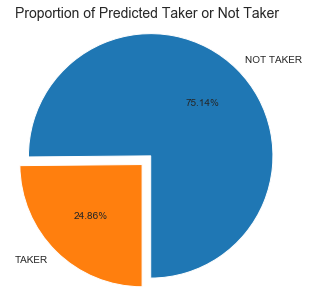

In [136]:
#Added by Amal
labels = 'NOT TAKER', 'TAKER'
sizes = [df_flag_taker_predict.flag_taker_pred[df_flag_taker_predict['flag_taker_pred']==0].count(), 
         df_flag_taker_predict.flag_taker_pred[df_flag_taker_predict['flag_taker_pred']==1].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(5, 5))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%',
        startangle=270)
ax1.axis('equal')
plt.title("Proportion of Predicted Taker or Not Taker", size=14)
plt.show()

In [137]:
# edit by kobud
# dataframe combine with flag_taker predictions results

df_ojol_modeling['flag_taker_predict'] = flag_taker_predict
df_ojol_modeling.reset_index(drop=True, inplace=True)

display(df_ojol_modeling)
display(df_ojol_modeling.flag_taker_predict.value_counts())

total_revenue  rev_voice  rev_sms  rev_broadband  rev_data_pack  \
0               10092       8132      800              0              0   
1              133657      11200     1238              0              0   
2               30006      11200     1238              0              0   
3               44503       7133      200              0              0   
4                5073       4473      600              0              0   
5                3512        662      400              0              0   
6               35001      11200     1238              0              0   
7               20010      11200     1000              0              0   
8                8518       8463        0              0              0   
9               95000      11200      825          11519              0   
10             202272       3969     1238         187500         187500   
11             202272      11200      495         187500         187500   
12             124503      11200      990         109000         109000   
13             191476       1076        0         187500         187500   
14             202272        750      660         187500         187500   
15              94634      11200      330          63000          63000   
16              79240          0     1238          75000          75000   
17             202272      11200     1238         187500         187500   
18             202272      11200        0          34470          28000   
19              28862       6199     1238           2713           1000   
20              79789       4464      325          75000          75000   
21             143980      11200      495          76485          61000   
22                971        646      325              0              0   
23              55799      11200      165          26266              0   
24              78300          0        0          75000          75000   
25              91000        259      350          90391          65000   
26              98498      11200     1238          65000          65000   
27              62496      11200      330          45719          40000   
28              72021       5701        0          65000          65000   
29             129025          0     1238         120000         120000   
...               ...        ...      ...            ...            ...   
301126          75113          0        0          75113          75003   
301127         165000       4755        0         160245         160000   
301128         202272      11200      325         160179         160002   
301129         150965      11200      495         122958         113002   
301130          76325          0      325          76000          75000   
301131          30000         95        0          29905           1000   
301132          74865      11200     1238          28356              0   
301133          95001      11200        0          75001          75001   
301134          90000          0        0          90000          90000   
301135         202272       2450        0         187500         187500   
301136         177346      11200        0          85000          85000   
301137          10126       4762      165           5009              0   
301138         104842      11200     1238             78              0   
301139          26452       1075      325          25052          20000   
301140           1916       1421      495              0              0   
301141          90583      11200     1238          52000          52000   
301142         202272       4500     1238         187500         187500   
301143         202272      11200      660         170162         159008   
301144          99728      11200      660            689              0   
301145          65290      11200      165             10              0   
301146          73384      11200      495              0              0   
301147         202272      11200 

0    226298
1     74858
Name: flag_taker_predict, dtype: int64

# CLUSTERING AND CUSTOMER SEGMENTATION

## Clustering using predicted taker (1 only)

In [138]:
df_ojol_taker_clustering = df_ojol_modeling[df_ojol_modeling['flag_taker_predict']==1].copy()

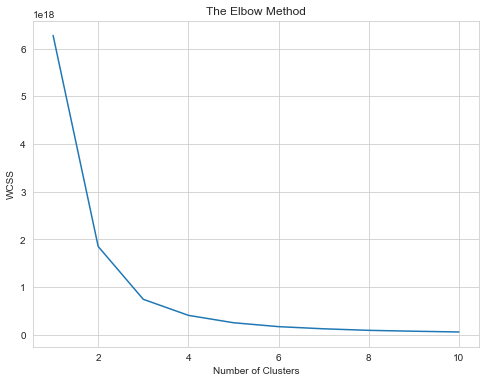

In [139]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 99)
    kmeans.fit(df_ojol_taker_clustering)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [140]:
from sklearn.metrics import silhouette_score
for num_clusters in range(2,6):
    clusterer = KMeans(n_clusters=num_clusters, n_jobs=4)
    preds = clusterer.fit_predict(df_ojol_taker_clustering)
    # centers = clusterer.cluster_centers_
    score = silhouette_score (df_ojol_taker_clustering, preds, metric='euclidean')
    print ("For n_clusters = {}, Kmeans silhouette score is {})".format(num_clusters, score))

For n_clusters = 2, Kmeans silhouette score is 0.6026556727123096)
For n_clusters = 3, Kmeans silhouette score is 0.6022067310076339)
For n_clusters = 4, Kmeans silhouette score is 0.5933777998273047)
For n_clusters = 5, Kmeans silhouette score is 0.5902399199027822)


In [141]:
# #Edited by Amal -> mau coba Silhouette Plot lagi
# #Coba Silhouette Plot lemot banget, code-nya refers to: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
# #Cari yang simple, error di package-nya 'kmeansplots', gak bisa di-install: https://gist.github.com/clintval/e9afc246e77f6488cda79f86e4d37148

# #Masih error yg dari scikit-learn.org, coba lagi!
# #from sklearn.datasets import make_blobs
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_samples, silhouette_score

# import matplotlib.pyplot as plt
# import matplotlib.cm as cm
# import numpy as np

# #print(__doc__)

# # Generating the sample data from make_blobs
# # This particular setting has one distinct cluster and 3 clusters placed close
# # together.
# # X, y = make_blobs(n_samples=500,
# #                   n_features=2,
# #                   centers=4,
# #                   cluster_std=1,
# #                   center_box=(-10.0, 10.0),
# #                   shuffle=True,
# #                   random_state=1)  # For reproducibility

# range_n_clusters = [2, 3, 4, 5, 6]

# for n_clusters in range_n_clusters:
#     # Create a subplot with 1 row and 2 columns
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     fig.set_size_inches(18, 7)

#     # The 1st subplot is the silhouette plot
#     # The silhouette coefficient can range from -1, 1 but in this example all
#     # lie within [-0.1, 1]
#     ax1.set_xlim([-0.1, 1])
#     # The (n_clusters+1)*10 is for inserting blank space between silhouette
#     # plots of individual clusters, to demarcate them clearly.
#     ax1.set_ylim([0, len(df_ojol_taker_clustering) + (n_clusters + 1) * 10])

#     # Initialize the clusterer with n_clusters value and a random generator
#     # seed of 10 for reproducibility.
#     clusterer = KMeans(n_clusters=n_clusters, random_state=10)
#     cluster_labels = clusterer.fit_predict(df_ojol_taker_clustering)

#     # The silhouette_score gives the average value for all the samples.
#     # This gives a perspective into the density and separation of the formed
#     # clusters
#     silhouette_avg = silhouette_score(df_ojol_taker_clustering, cluster_labels)
#     print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_avg)

#     # Compute the silhouette scores for each sample
#     sample_silhouette_values = silhouette_samples(df_ojol_taker_clustering, cluster_labels)

#     y_lower = 10
#     for i in range(n_clusters):
#         # Aggregate the silhouette scores for samples belonging to
#         # cluster i, and sort them
#         ith_cluster_silhouette_values = \
#             sample_silhouette_values[cluster_labels == i]

#         ith_cluster_silhouette_values.sort()

#         size_cluster_i = ith_cluster_silhouette_values.shape[0]
#         y_upper = y_lower + size_cluster_i

#         color = cm.nipy_spectral(float(i) / n_clusters)
#         ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values,facecolor=color, edgecolor=color, alpha=0.7)

#         # Label the silhouette plots with their cluster numbers at the middle
#         ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

#         # Compute the new y_lower for next plot
#         y_lower = y_upper + 10  # 10 for the 0 samples

#     ax1.set_title("The silhouette plot for the various clusters.")
#     ax1.set_xlabel("The silhouette coefficient values")
#     ax1.set_ylabel("Cluster label")

#     # The vertical line for average silhouette score of all the values
#     ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

#     ax1.set_yticks([])  # Clear the yaxis labels / ticks
#     ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

#     # 2nd Plot showing the actual clusters formed
#     colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
#     ax2.scatter(df_ojol_taker_clustering[:, 0], df_ojol_taker_clustering[:, 1], marker='.', s=30, lw=0, alpha=0.7,c=colors, edgecolor='k')

#     # Labeling the clusters
#     centers = clusterer.cluster_centers_
#     # Draw white circles at cluster centers
#     ax2.scatter(centers[:, 0], centers[:, 1], marker='o',c="white", alpha=1, s=200, edgecolor='k')

#     for i, c in enumerate(centers):
#         ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,s=50, edgecolor='k')

#     ax2.set_title("The visualization of the clustered data.")
#     ax2.set_xlabel("Feature space for the 1st feature")
#     ax2.set_ylabel("Feature space for the 2nd feature")

#     plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
#                   "with n_clusters = %d" % n_clusters),
#                  fontsize=14, fontweight='bold')

# plt.show()

In [142]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=99)
y_kmeans = kmeans.fit_predict(df_ojol_taker_clustering)
df_ojol_taker_clustering['cluster'] = y_kmeans

display(df_ojol_taker_clustering)

# y_kmeans_2 = pd.DataFrame(y_kmeans, columns=['cluster'])
# y_kmeans_2.reset_index(drop=True, inplace=True)
# df_ojol_modeling_taker.reset_index(drop=True, inplace=True)
# df_final_1_v2 = df_ojol_modeling_taker.join(y_kmeans_2)
# df_final_1_v2

total_revenue  rev_voice  rev_sms  rev_broadband  rev_data_pack  \
13             191476       1076        0         187500         187500   
14             202272        750      660         187500         187500   
16              79240          0     1238          75000          75000   
20              79789       4464      325          75000          75000   
24              78300          0        0          75000          75000   
29             129025          0     1238         120000         120000   
30              26201          0      495          14256          11000   
37              75895          0      495          75000          75000   
46             150306        300        0         150006         150000   
53              75000          0        0          75000          75000   
59              75000          0        0          75000          75000   
61             111510          0     1155          97580          75000   
65             202272          0        0          90000          90000   
66              30000          0        0          30000          28000   
69             202272          0        0         187500         187500   
74             126045          0     1238         109000         109000   
78             108186          0      350         105636          75000   
83             152199          0      165         151684         150000   
92              89130       3000        0          86130          75000   
97             152380          0        0         150000         150000   
99              17659          0        0          17309          15001   
105            202272          0        0         187500         187500   
110            124330          0      650          80000          80000   
116             25000          0        0          25000          25000   
122             79450          0     1238          75000          75000   
126             93850          0      650          80000          80000   
134             77130          0      330          75000          75000   
139             10000          0        0           3000              0   
140            166422        628        0         165794         160000   
145            103800          0        0         103800          98000   
...               ...        ...      ...            ...            ...   
301065          75000          0        0          75000          75000   
301066          93489       4663        0          88826          75010   
301067         202272       1907        0         187500         187500   
301071         103850       1877     1238          79498          75000   
301078           8816          0        0            236              0   
301081          85372          0        0          85372          85000   
301083          90085          0        0          90010          90001   
301085          75000          0        0          75000          75000   
301086         127734       4948      325         115121         115001   
301089          90000          0        0          90000          90000   
301098          78576          0        0          78576          75000   
301100          77850          0      650          75000          75000   
301102         150060          0        0         150060         150000   
301107         160000          0     1238         154750         150000   
301110          78708       3213      495          75000          75000   
301117          16001          0      165          15836          15001   
301119         160151          0        0         160151         150001   
301122         100000          0        0         100000         100000   
301123          45003          0        0          45003          45003   
301124         175000       1478      650         172872         160000   
301126          75113          0        0          75113          75003   
301127         165000       4755 

## Export to CSV to do customer profiling

In [143]:
df_ojol_taker_clustering.to_csv('df_ojol_taker_clustering_n3_v3.csv', index = False)